# <span style="color:#f37726">06 RKI Model Testing</span>

**Ziele des Notebooks:**

- Vorhersagemodelle im Testzeitraum anwenden
- Abweichung der Vorhersagen zur tatsächlichen Ausprägung plotten
- Evaluierungsmetriken berechnen

In [1]:
# Benötigte Bibliotheken für dieses Notebook
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import statsmodels.tsa as sm
from tensorflow import keras

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
bechmark_kreise_ids = [2000, 8317, 15082, 14628] # Hamburg, Ortenau, Anhalt-Bitterfeld, Sächsische Schweiz-Osterzgebirge

## Single-Period-Vorhersage
Täglich neu im Zeitraum 01. April 2021 bis 20. Mai 2021

**1) Naïve / SNaïve**

In [4]:
# Daten laden
test_naive = pd.read_pickle('data/test_naive.pkl')

# Vorhersage
test_naive['AnzahlFall_Vorhersage'] = test_naive['AnzahlFall_Vorwoche'] 

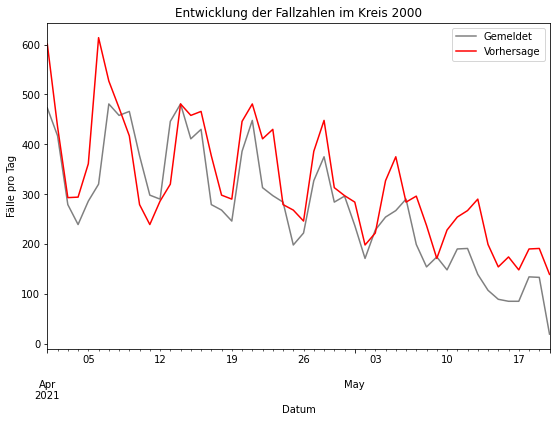

MSE
63.7


R²
0.5310194716596489


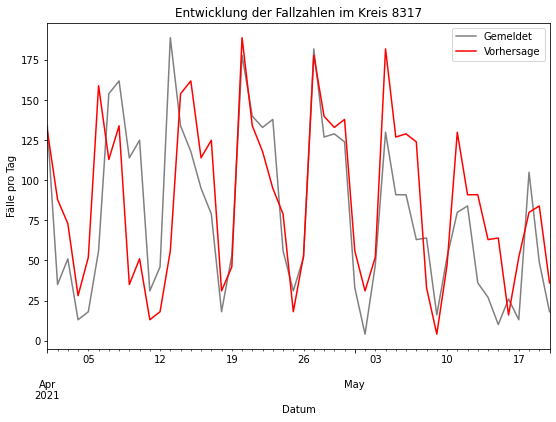

MSE
30.92


R²
0.39169224214974485


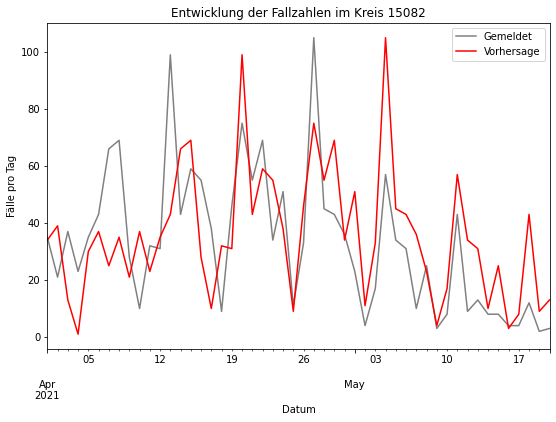

MSE
16.64


R²
0.277354642469374


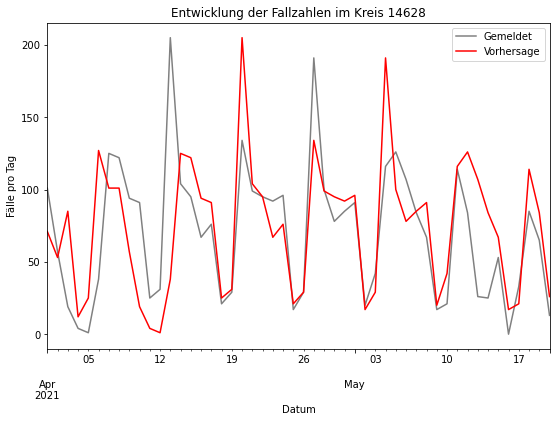

MSE
27.68


R²
0.21067059525585552


In [5]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten
    df = test_naive.xs(kreis_id)
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/naive_single_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**2) SNaïve mit wöchentlicher Trendkomponente**

In [6]:
# Daten laden
test_naive_trend = pd.read_pickle('data/test_naive_trend.pkl')

# Vorhersage
test_naive_trend['AnzahlFall_Vorhersage'] = test_naive_trend['AnzahlFall_Vorwoche']*(test_naive_trend['AnzahlFall_Vortag']/test_naive_trend['AnzahlFall_Vortagwoche'])
test_naive_trend['AnzahlFall_Vorhersage'].fillna(test_naive_trend['AnzahlFall_Vorwoche'], inplace=True) # Division durch 0
test_naive_trend['AnzahlFall_Vorhersage'] = test_naive_trend['AnzahlFall_Vorhersage'].round()
#test_naive_trend['AnzahlFall_Vorhersage'] = test_naive_trend['AnzahlFall_Vorhersage'].astype(int)

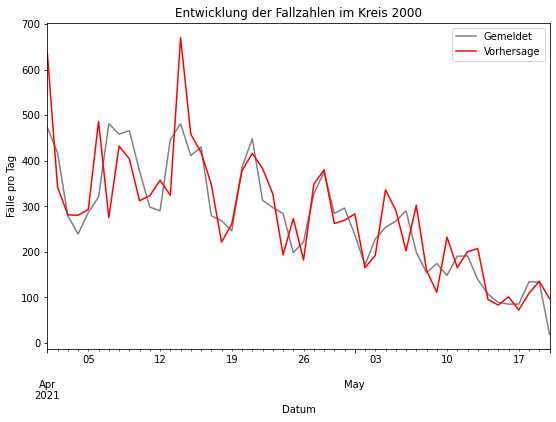

MSE
52.36
R²
0.6375011313685237


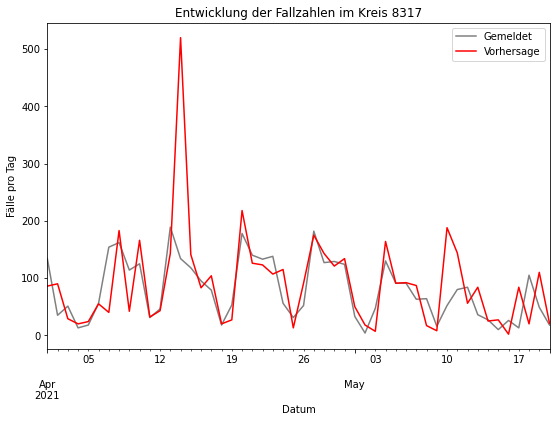

MSE
37.74
R²
-0.7596581909575244


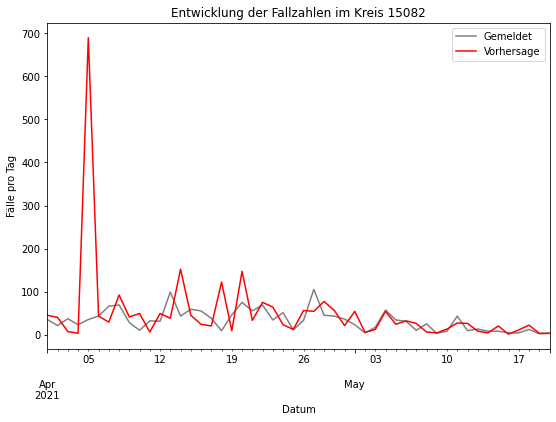

MSE
34.66
R²
-15.2041552276444


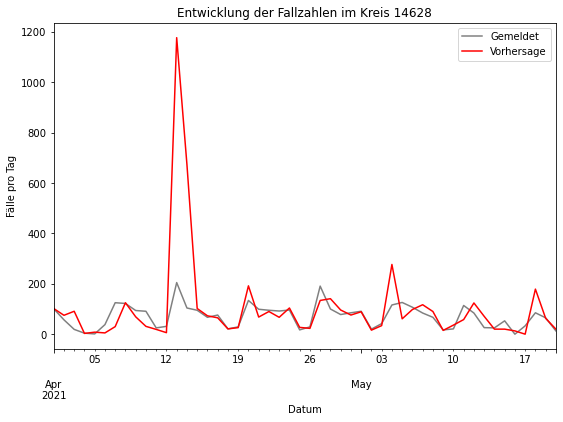

MSE
56.68
R²
-11.616570938385799


In [7]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten
    df = test_naive_trend.xs(kreis_id)
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/naivetrend_single_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
    
        # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**3) Exponentielle Glättung**

In [8]:
# Daten laden
train_smoothing = pd.read_pickle('data/train_smoothing.pkl')
test_smoothing = pd.read_pickle('data/test_smoothing.pkl')

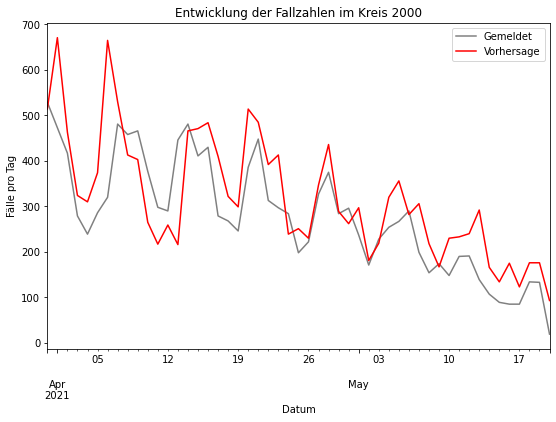

MSE
68.82352941176471
R²
0.44684158020515563


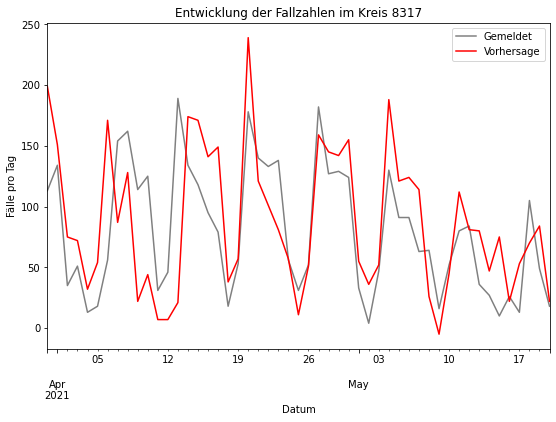

MSE
37.78431372549019
R²
0.10549284090797328


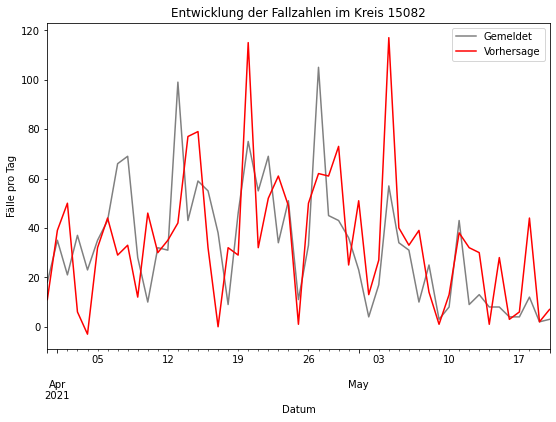

MSE
18.686274509803923
R²
0.031140791270904633


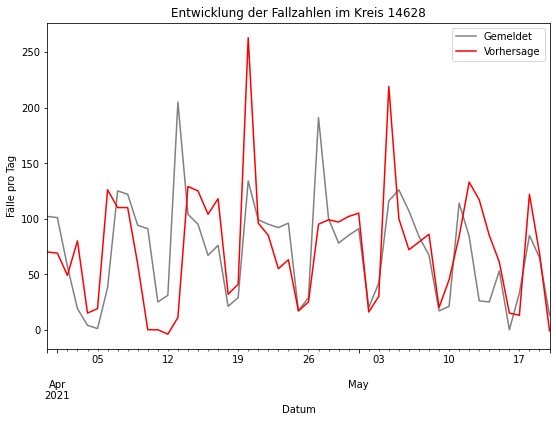

MSE
34.03921568627451
R²
-0.1889015091817159


In [9]:
alpha = 0.3

for kreis_id in bechmark_kreise_ids:
    
    # Daten pro Kreis
    df1 = train_smoothing.xs(kreis_id)
    df2 = test_smoothing.xs(kreis_id)
    df = pd.concat([df1, df2])
    df['AnzahlFall_Vorhersage'] = np.nan
    
    
    # Vorhersage
    for date in df.index:
     
        row_values = df.loc[date]
    
        if date < pd.to_datetime('2020-03-08'):
            df.loc[date, 'AnzahlFall_Vorhersage'] = row_values['AnzahlFall'] # Erste 7 Tage initialisieren
        
        else:
            date_lastweek = date-pd.to_timedelta(7, unit='d')
            case_prediction_lastweek = df.loc[date_lastweek, 'AnzahlFall_Vorhersage']
            df.loc[date, 'AnzahlFall_Vorhersage'] = row_values['AnzahlFall_Vorwoche'] + alpha*(row_values['AnzahlFall_Vorwoche'] - case_prediction_lastweek)
 
    df['AnzahlFall_Vorhersage'] = df['AnzahlFall_Vorhersage'].astype(int)

    
    # Daten Plot
    df_predict = df['2021-03-31':]
    yPlot = df_predict['AnzahlFall']
    zPlot = df_predict['AnzahlFall_Vorhersage']

    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/smoothing_single_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df_predict['AnzahlFall'], y_pred=df_predict['AnzahlFall_Vorhersage']))
    
     # R²
    print("R²")
    print(r2_score(y_true=df_predict['AnzahlFall'], y_pred=df_predict['AnzahlFall_Vorhersage']))

**4) ARIMA**

In [10]:
# Daten laden
train_arima = pd.read_pickle('data/train_arima.pkl')
test_arima = pd.read_pickle('data/test_arima.pkl')

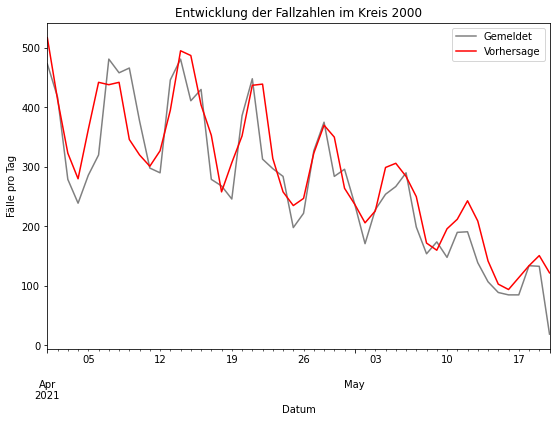

MSE
38.26
R²
0.8247385318781595


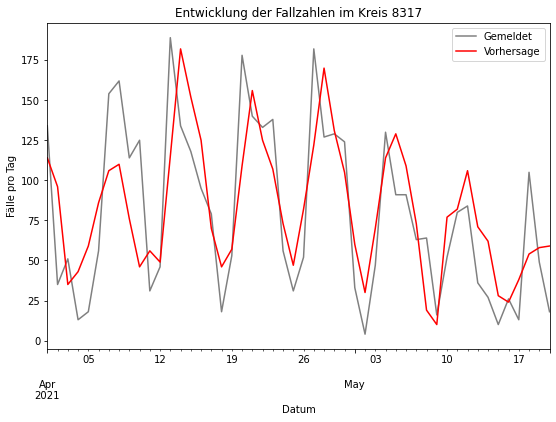

MSE
29.1
R²
0.5522480641372425


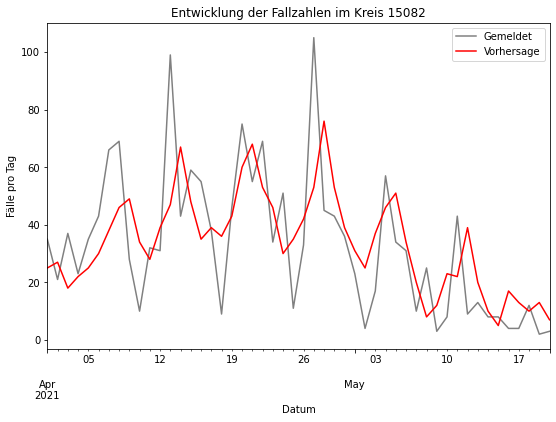

MSE
14.88
R²
0.4208868688555949


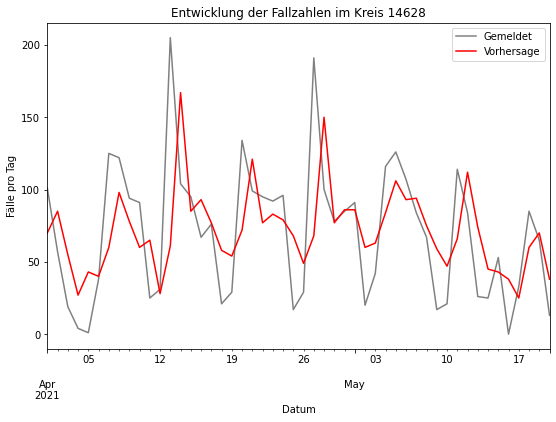

MSE
29.88
R²
0.24418170968223174


In [11]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten pro Kreis
    df_train = train_arima.xs(kreis_id)
    df_test = test_arima.xs(kreis_id)
    df = pd.concat([df_train, df_test])
    df_test['AnzahlFall_Vorhersage'] = np.nan
    
    # Grid Search
    #grid_search=pmdarima.auto_arima(df_train['AnzahlFall'], trace=True) # Bestes Ergebnis: >> ARIMA(5,1,2)(0,0,0)[0] <<
    
    
    # Vorhersage
    for date in df_test.index:
    
        train_set = df[:date]
        train_set = train_set['AnzahlFall']
        model = sm.arima.model.ARIMA(train_set, order=(5, 1, 2))
        model = model.fit()
        prediction = model.predict(date)
        df_test.loc[date, 'AnzahlFall_Vorhersage'] = prediction[0]

    df_test['AnzahlFall_Vorhersage'] =  df_test['AnzahlFall_Vorhersage'].astype(int)
    
    
    # Daten Plot
    yPlot = df_test['AnzahlFall']
    zPlot = df_test['AnzahlFall_Vorhersage']

    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/arima_single_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df_test['AnzahlFall'], y_pred=df_test['AnzahlFall_Vorhersage']))
    
    # R²
    print("R²")
    print(r2_score(y_true=df_test['AnzahlFall'], y_pred=df_test['AnzahlFall_Vorhersage']))

**5) MLP ohne Landkreisdaten**

In [12]:
# Test MLP

model = keras.models.load_model('models/mlp.h5')
test_mlp = pd.read_pickle('data/test_mlp.pkl')
X_test = test_mlp[['AnzahlFall_Vortag', 'AnzahlFall_Vorzweitag', 'AnzahlFall_Vordreitag', 'AnzahlFall_Vorviertag', 'AnzahlFall_Vorfünftag', 'AnzahlFall_Vorsechstag', 'AnzahlFall_Vorwoche', 'Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']]
X_test = X_test.to_numpy()
y_test = test_mlp['AnzahlFall']
y_test = y_test.to_numpy()
y_predict = model.predict(X_test)
test_mlp['AnzahlFall_Vorhersage'] = y_predict
test_mlp = test_mlp.groupby(['IdLandkreis', 'Meldedatum']).last() # Multiindex
display(test_mlp)

AnzahlFall  AnzahlFall_Vortag  AnzahlFall_Vorzweitag  \
IdLandkreis Meldedatum                                                         
1001        2021-04-01          14                 15                     10   
            2021-04-02          19                 14                     15   
            2021-04-03          12                 19                     14   
            2021-04-04           4                 12                     19   
            2021-04-05           7                  4                     12   
...                            ...                ...                    ...   
16077       2021-05-16           0                  3                     15   
            2021-05-17           9                  0                      3   
            2021-05-18          22                  9                      0   
            2021-05-19           0                 22                      9   
            2021-05-20           4                  0                     22   

                        AnzahlFall_Vordreitag  AnzahlFall_Vorviertag  \
IdLandkreis Meldedatum                                                 
1001        2021-04-01                      9                      4   
            2021-04-02                     10                      9   
            2021-04-03                     15                     10   
            2021-04-04                     14                     15   
            2021-04-05                     19                     14   
...                                       ...                    ...   
16077       2021-05-16                      6                     25   
            2021-05-17                     15                      6   
            2021-05-18                      3                     15   
            2021-05-19                      0                      3   
            2021-05-20                      9                      0   

                        AnzahlFall_Vorfünftag  AnzahlFall_Vorsechstag  \
IdLandkreis Meldedatum                                                  
1001        2021-04-01                     11                      24   
            2021-04-02                      4                      11   
            2021-04-03                      9                       4   
            2021-04-04                     10                       9   
            2021-04-05                     15                      10   
...                                       ...                     ...   
16077       2021-05-16                     40                       6   
            2021-05-17                     25                      40   
            2021-05-18                      6                      25   
            2021-05-19                     15                       6   
            2021-05-20                      3                      15   

                        AnzahlFall_Vorwoche  Dienstag  Donnerstag  Freitag  \
IdLandkreis Meldedatum                                                       
1001        2021-04-01                   21         0           0        0   
            2021-04-02                   24         0           1        0   
            2021-04-03                   11         0           0        0   
            2021-04-04                    4         0           0        0   
            2021-04-05                    9         0           0        0   
...                                     ...       ...         ...      ...   
16077       2021-05-16                   10         0           0        0   
            2021-05-17                    6         0           0        0   
            2021-05-18                   40         0           0        1   
            2021-05-19                   25         1           0        0   
            2021-05-20                    6         0           0        0   

                        Mittwoch  Montag  Samstag  Sonntag  \
IdLandkreis Meldeda

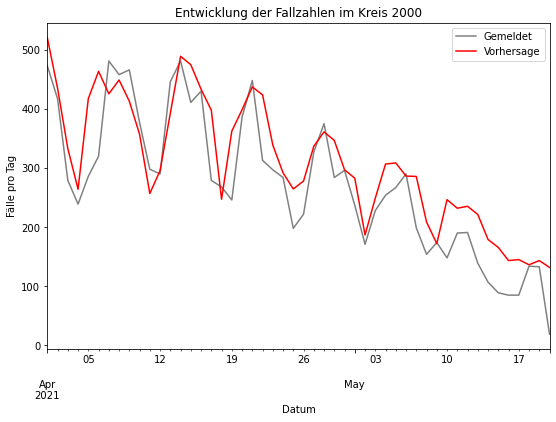

MSE
47.32289947509766
R²
0.7405465971707046


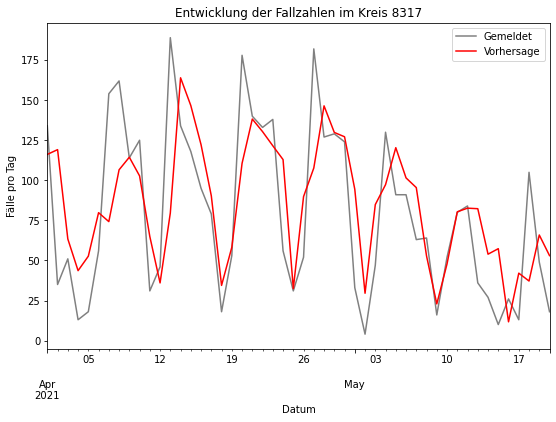

MSE
29.062489433288576
R²
0.4561457757602305


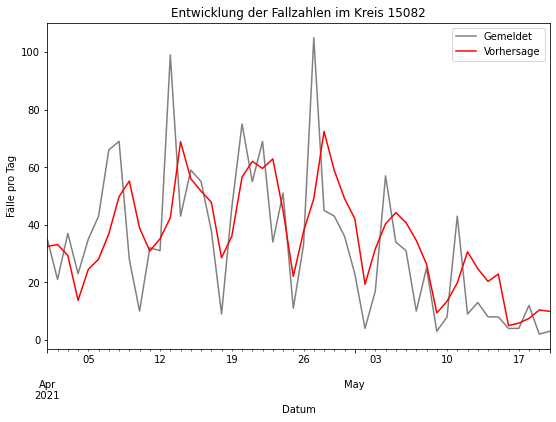

MSE
14.451683883666993
R²
0.4162597198142043


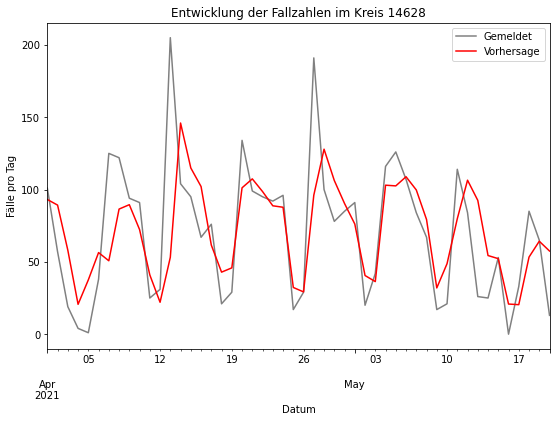

MSE
25.050279006958007
R²
0.39498248789132806


In [13]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten
    df = test_mlp.xs(kreis_id)
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/mlp_single_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
          
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**6) MLP mit den Ergebnissen des Clusterings**

In [14]:
# Test MLP

model = keras.models.load_model('models/mlp_mit.h5')
test_mlp_mit = pd.read_pickle('data/test_mlp_mit.pkl')
X_test = test_mlp_mit.copy()
X_test.drop('IdLandkreis', axis=1, inplace=True)
X_test.drop('Meldedatum', axis=1, inplace=True)
X_test.drop('AnzahlFall', axis=1, inplace=True)
X_test = X_test.to_numpy()
y_test = test_mlp_mit['AnzahlFall']
y_test = y_test.to_numpy()
y_predict = model.predict(X_test)
test_mlp_mit['AnzahlFall_Vorhersage'] = y_predict
test_mlp_mit = test_mlp_mit.groupby(['IdLandkreis', 'Meldedatum']).last() # Multiindex
display(test_mlp_mit)

AnzahlFall  AnzahlFall_Vortag  AnzahlFall_Vorzweitag  \
IdLandkreis Meldedatum                                                         
1001        2021-04-01          14                 15                     10   
            2021-04-02          19                 14                     15   
            2021-04-03          12                 19                     14   
            2021-04-04           4                 12                     19   
            2021-04-05           7                  4                     12   
...                            ...                ...                    ...   
16077       2021-05-16           0                  3                     15   
            2021-05-17           9                  0                      3   
            2021-05-18          22                  9                      0   
            2021-05-19           0                 22                      9   
            2021-05-20           4                  0                     22   

                        AnzahlFall_Vordreitag  AnzahlFall_Vorviertag  \
IdLandkreis Meldedatum                                                 
1001        2021-04-01                      9                      4   
            2021-04-02                     10                      9   
            2021-04-03                     15                     10   
            2021-04-04                     14                     15   
            2021-04-05                     19                     14   
...                                       ...                    ...   
16077       2021-05-16                      6                     25   
            2021-05-17                     15                      6   
            2021-05-18                      3                     15   
            2021-05-19                      0                      3   
            2021-05-20                      9                      0   

                        AnzahlFall_Vorfünftag  AnzahlFall_Vorsechstag  \
IdLandkreis Meldedatum                                                  
1001        2021-04-01                     11                      24   
            2021-04-02                      4                      11   
            2021-04-03                      9                       4   
            2021-04-04                     10                       9   
            2021-04-05                     15                      10   
...                                       ...                     ...   
16077       2021-05-16                     40                       6   
            2021-05-17                     25                      40   
            2021-05-18                      6                      25   
            2021-05-19                     15                       6   
            2021-05-20                      3                      15   

                        AnzahlFall_Vorwoche  Dienstag  Donnerstag  ...  \
IdLandkreis Meldedatum                                             ...   
1001        2021-04-01                   21         0           0  ...   
            2021-04-02                   24         0           1  ...   
            2021-04-03                   11         0           0  ...   
            2021-04-04                    4         0           0  ...   
            2021-04-05                    9         0           0  ...   
...                                     ...       ...         ...  ...   
16077       2021-05-16                   10         0           0  ...   
            2021-05-17                    6         0           0  ...   
            2021-05-18                   40         0           0  ...   
            2021-05-19                   25         1           0  ...   
            2021-05-20                    6         0           0  ...   

                        is_kmeans_cluster_7  is_agglo_cluster_0  \
IdLandkreis Meldedatum                                            

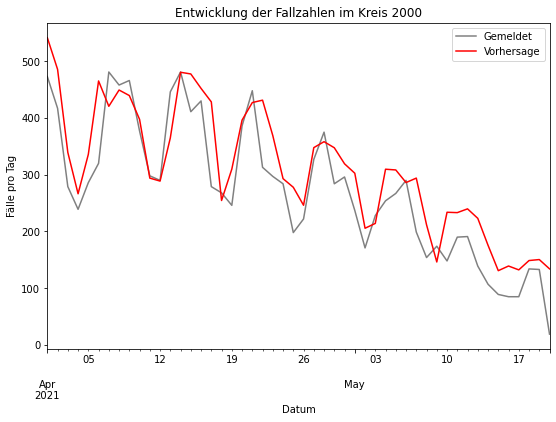

MSE
48.26754638671875
R²
0.7438532802674653


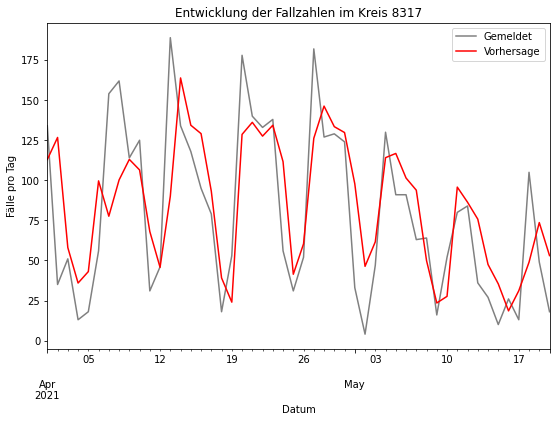

MSE
27.351825942993162
R²
0.527477677878797


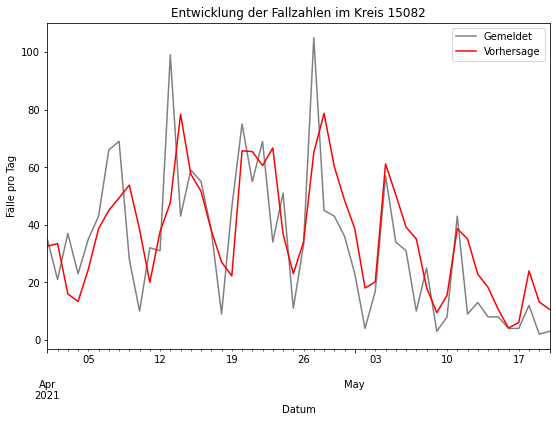

MSE
13.843039360046387
R²
0.46845106480512033


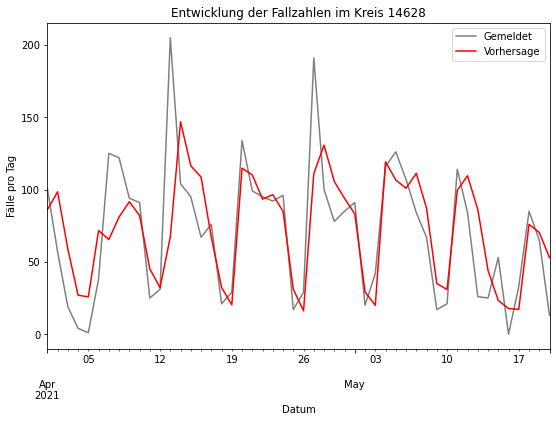

MSE
23.706678047180176
R²
0.49074944254109676


In [15]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten
    df = test_mlp_mit.xs(kreis_id)
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/mlp_mit_single_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
          
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**7) RNN**

In [16]:
# Test RNN
model = keras.models.load_model('models/rnn.h5')
test_rnn = pd.read_pickle('data/test_rnn.pkl')

with open("data/fallzahlen_minmax.json", "rb") as infile: 
    fallzahlen_minmax = json.load(infile)

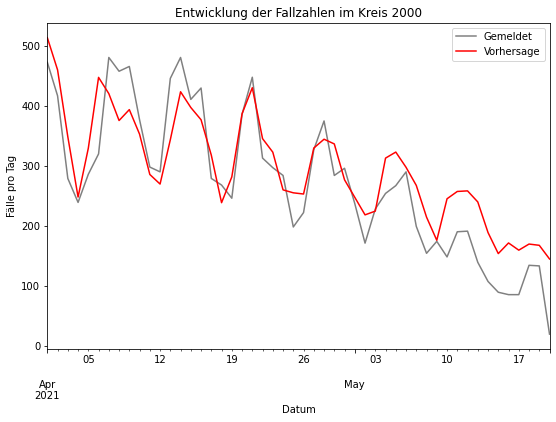

MSE
47.57720153808594


R²
0.7684717089916985


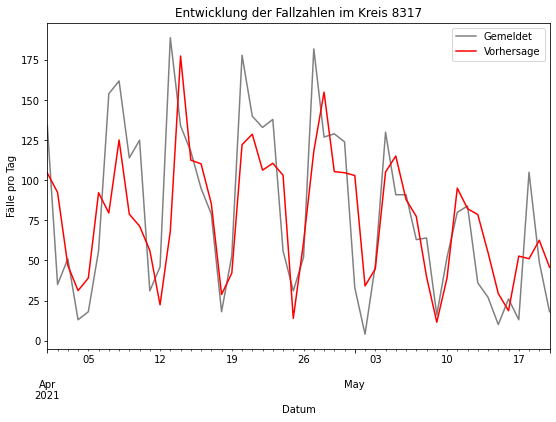

MSE
28.348112907409668


R²
0.5145225237392519


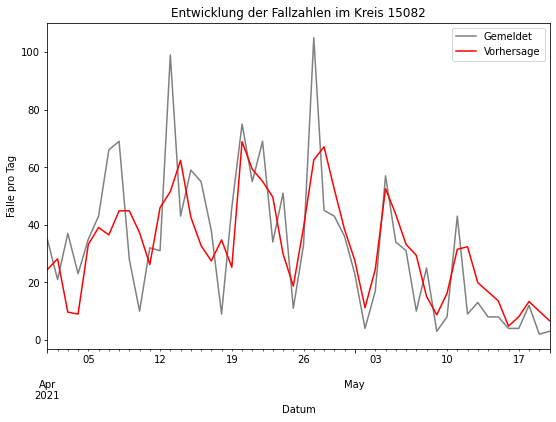

MSE
12.995766868591309


R²
0.5410048735671298


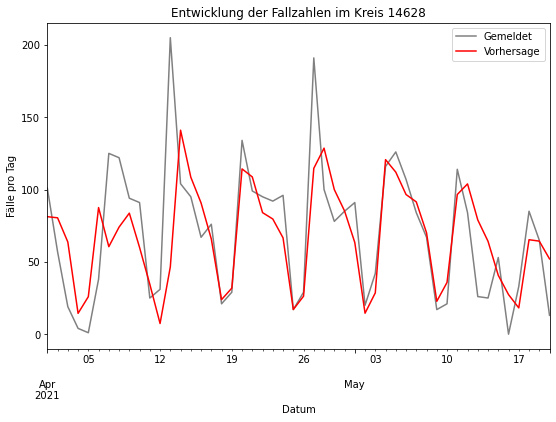

MSE
23.414851312637328


R²
0.4395432326653512


In [17]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten Vorbereitung
    df = test_rnn.xs(kreis_id)
    kreis_min = fallzahlen_minmax[f'{kreis_id}'][0]
    kreis_max = fallzahlen_minmax[f'{kreis_id}'][1]
    
    X_pred = df.drop('AnzahlFall', axis=1, inplace=False)
    y_test = df['AnzahlFall']
    X_pred = X_pred.to_xarray().to_array()
    X_pred = X_pred.transpose()
    X_pred = X_pred.values
    X_pred = np.expand_dims(X_pred, axis=2)

    # Vorhersage
    y_pred = model.predict(X_pred)
        
    
     # Daten 
    df['AnzahlFall_Vorhersage'] = y_pred
    yPlot = df['AnzahlFall']*(kreis_max-kreis_min)+kreis_min
    zPlot = df['AnzahlFall_Vorhersage']*(kreis_max-kreis_min)+kreis_min
    
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/rnn_single_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=yPlot, y_pred=zPlot))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=yPlot, y_pred=zPlot))
    

In [18]:
# X_test = test_rnn.drop('AnzahlFall', axis=1, inplace=False)
# X_test_lstm = X_test['AnzahlFall_Vortag']
# X_test_aux = X_test.drop('AnzahlFall_Vortag', axis=1, inplace=False)

# X_test_lstm = X_test_lstm.to_xarray()
# X_test_aux = X_test_aux.to_xarray().to_array()

# X_test_lstm = X_test_lstm.expand_dims("variable")
# X_test_lstm = X_test_lstm.transpose('IdLandkreis', 'Meldedatum', 'variable')
# print("LSTM Testvektor")
# print(X_test_lstm.shape)
# print("IdLandkreis, Meldedatum, variable")
# print("")

# X_test_aux = X_test_aux.transpose('IdLandkreis', 'Meldedatum', 'variable')
# #X_train_mlp = X_train_mlp[:, 1, :] #  Gleicher Inputvektor für alle Tage
# print("Auxiliary Testvektor")
# print(X_test_aux.shape)
# print("IdLandkreis, Meldedatum, variable")
# print("")

In [19]:
# y_predict = model.predict((X_test_lstm, X_test_aux))
# y_predict = y_predict.flatten()
# print(y_predict.shape)
# test_rnn['AnzahlFall_Vorhersage'] = y_predict

In [20]:
# for kreis_id in bechmark_kreise_ids:
    
#     # Daten Plot
#     df = test_rnn.xs(kreis_id)
#     yPlot = df['AnzahlFall']
#     zPlot = df['AnzahlFall_Vorhersage']

    
#     # Line Plots
#     f, ax = plt.subplots(figsize=(9, 6))
#     yPlot.plot(color='grey')
#     zPlot.plot(color='red')
#     ax.set_xlabel('Datum')
#     ax.set_ylabel('Fälle pro Tag')
#     plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
#     ax.legend(('Gemeldet', 'Vorhersage'))
#     plt.savefig(f"visualization/forecast/rnn_total_{kreis_id}.svg")
#     plt.show()
    
#     # MSE
#     print("MSE")
#     print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
#     print("\n")
#     # R²
#     print("R²")
#     print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

## Multi-Period-Vorhersage
Für 7 Tagen beginnend am 01. April 2021

In [21]:
start_time = pd.to_datetime('2021-04-01')
end_time = pd.to_datetime('2021-04-07')
prediction_time = pd.date_range(start_time, end_time, freq='D')

**1) Naïve / SNaïve**

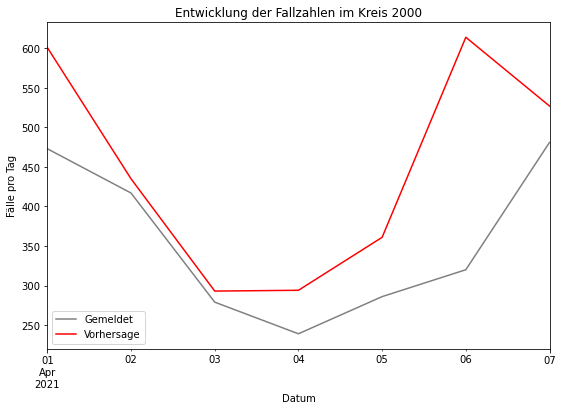

MSE
90.0


R²
-0.939004792029791


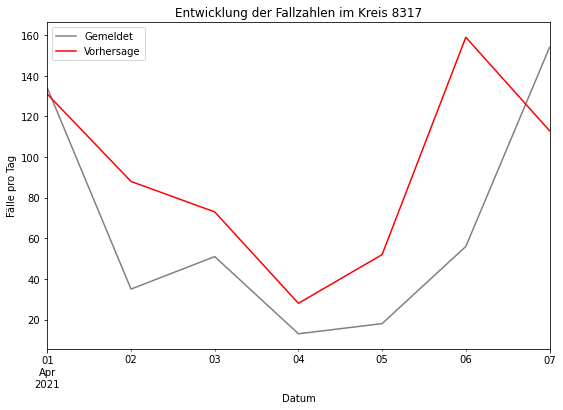

MSE
38.714285714285715


R²
0.09558644418732098


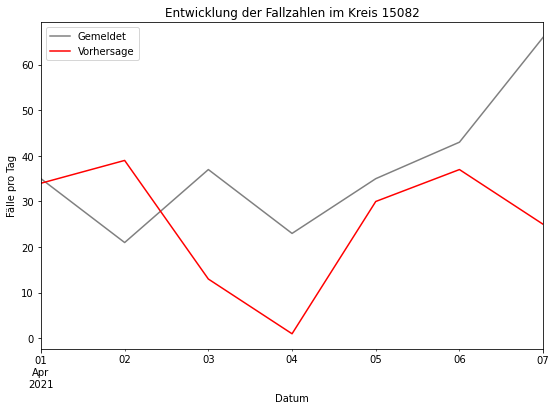

MSE
16.714285714285715


R²
-1.3390681769608892


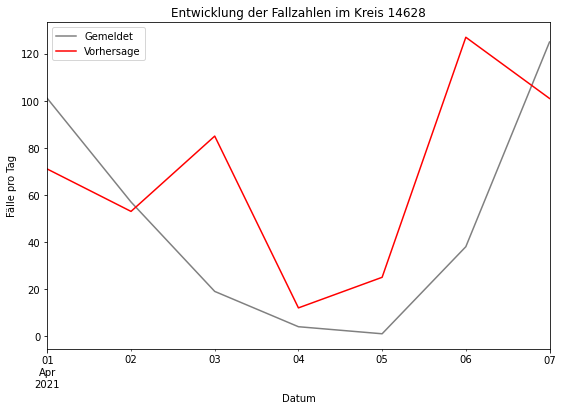

MSE
35.0


R²
-0.037109013511012146


In [22]:
# Daten laden
test_naive = pd.read_pickle('data/test_naive.pkl')


for kreis_id in bechmark_kreise_ids:
   
    # Vorhersage
    df = test_naive.xs(kreis_id)
    df_pred = df.loc[prediction_time]
    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorwoche'] 
    
    # Daten
    yPlot = df_pred['AnzahlFall']
    zPlot = df_pred['AnzahlFall_Vorhersage']
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/naive_seven_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))

**2) SNaïve mit wöchentlicher Trendkomponente**

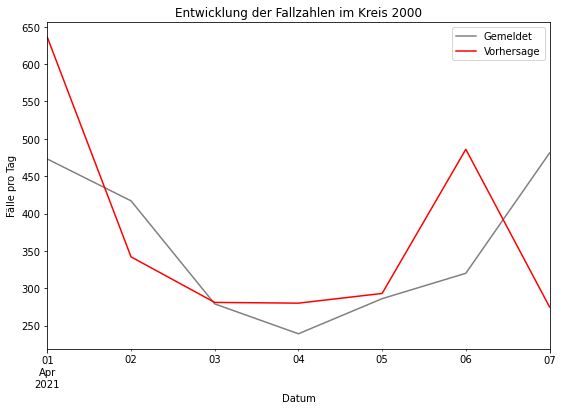

MSE
94.28571428571429


R²
-0.7659139570902134


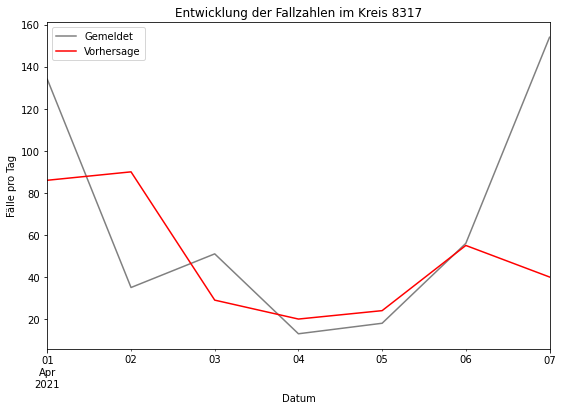

MSE
36.142857142857146


R²
-0.00682814688508615


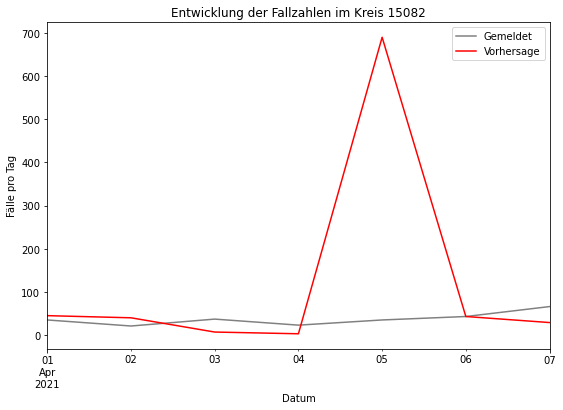

MSE
110.14285714285714


R²
-322.26191493908954


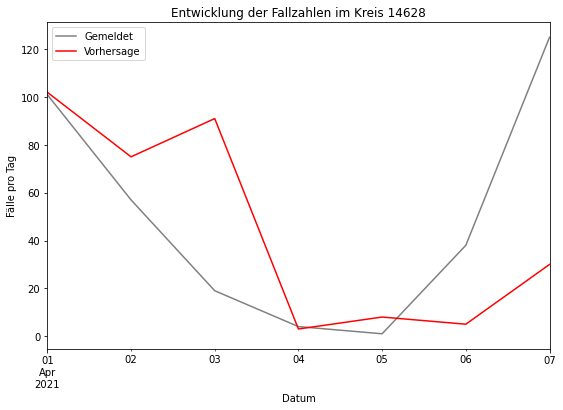

MSE
32.42857142857143


R²
-0.1280872766158716


In [23]:
# Daten laden
test_naive_trend = pd.read_pickle('data/test_naive_trend.pkl')

for kreis_id in bechmark_kreise_ids:
    
    # Vorhersage
    df = test_naive_trend.xs(kreis_id)
    df_pred = df.loc[prediction_time]
    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorwoche']*(df_pred['AnzahlFall_Vortag']/df_pred['AnzahlFall_Vortagwoche'])
    df_pred['AnzahlFall_Vorhersage'].fillna(df_pred['AnzahlFall_Vorwoche'], inplace=True) # Division durch 0
    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'].round()
    
    # Daten
    df = test_naive.xs(kreis_id)
    yPlot = df_pred['AnzahlFall']
    zPlot = df_pred['AnzahlFall_Vorhersage']
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/naivetrend_seven_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))

**3) Exponentielle Glättung**

In [24]:
# Daten laden
train_smoothing = pd.read_pickle('data/train_smoothing.pkl')
test_smoothing = pd.read_pickle('data/test_smoothing.pkl')

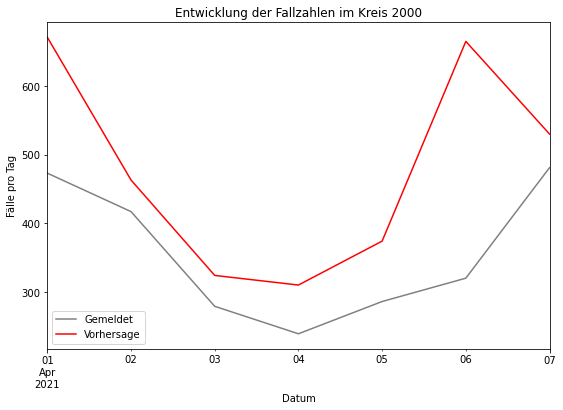

MSE
120.28571428571429


R²
-2.0172114950453226


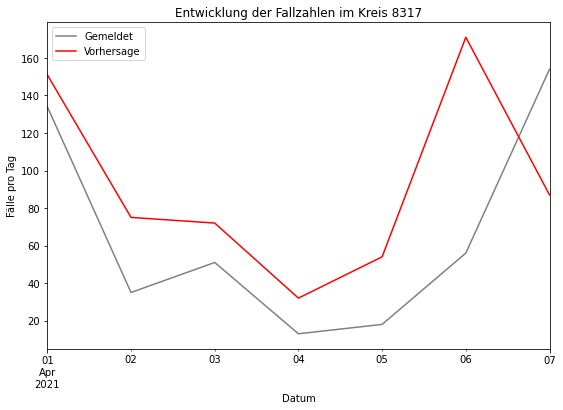

MSE
45.0


R²
-0.1563470555995372


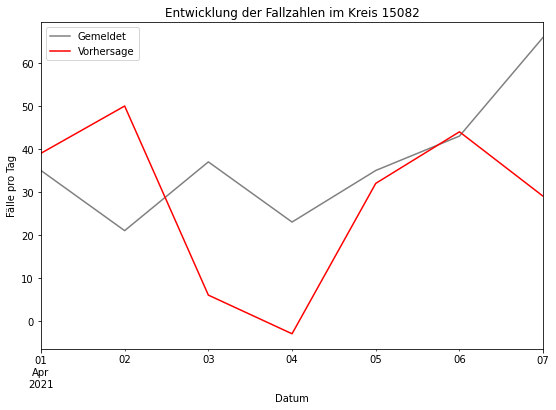

MSE
18.714285714285715


R²
-1.8970933960247915


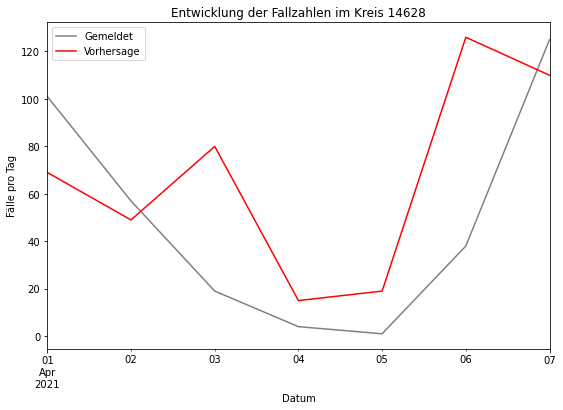

MSE
33.285714285714285


R²
0.04825508462376893


In [25]:
alpha = 0.3

for kreis_id in bechmark_kreise_ids:
    
    # Daten Vorbereitung Vorhersage
    df1 = train_smoothing.xs(kreis_id)
    df2 = test_smoothing.xs(kreis_id)
    df = pd.concat([df1, df2])
    df['AnzahlFall_Vorhersage'] = np.nan
    

    # Vorbereitung Vorhersage
    for date in df.index:
     
        row_values = df.loc[date]
    
        if date < pd.to_datetime('2020-03-08'):
            df.loc[date, 'AnzahlFall_Vorhersage'] = row_values['AnzahlFall'] # Erste 7 Tage initialisieren
        
        else:
            date_lastweek = date-pd.to_timedelta(7, unit='d')
            case_prediction_lastweek = df.loc[date_lastweek, 'AnzahlFall_Vorhersage']
            df.loc[date, 'AnzahlFall_Vorhersage'] = row_values['AnzahlFall_Vorwoche'] + alpha*(row_values['AnzahlFall_Vorwoche'] - case_prediction_lastweek)
 
    df['AnzahlFall_Vorhersage'] = df['AnzahlFall_Vorhersage'].astype(int)
    
    
    # Vorhersage
    df_pred = df.loc[prediction_time]
    
    # Daten
    yPlot = df_pred['AnzahlFall']
    zPlot = df_pred['AnzahlFall_Vorhersage']

    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/smoothing_seven_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))

**4) ARIMA**

In [26]:
# Daten laden
train_arima = pd.read_pickle('data/train_arima.pkl')
test_arima = pd.read_pickle('data/test_arima.pkl')

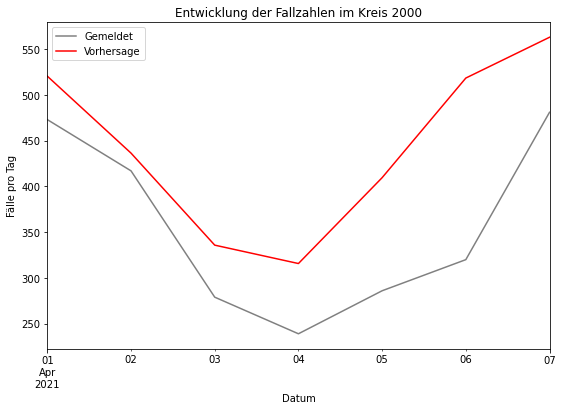

MSE
86.33903440541408


R²
-0.24222725092082342


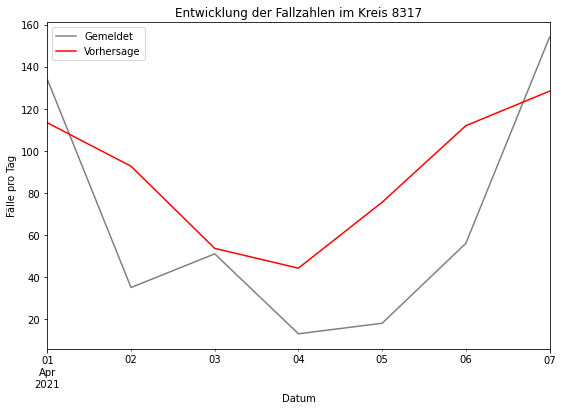

MSE
35.890574161385636


R²
0.36966962865194597


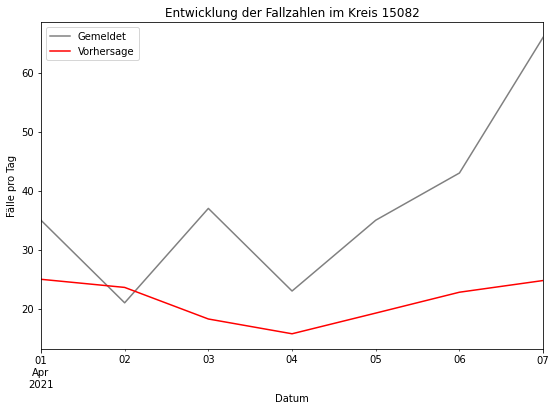

MSE
16.53855358900479


R²
-1.1436480288154942


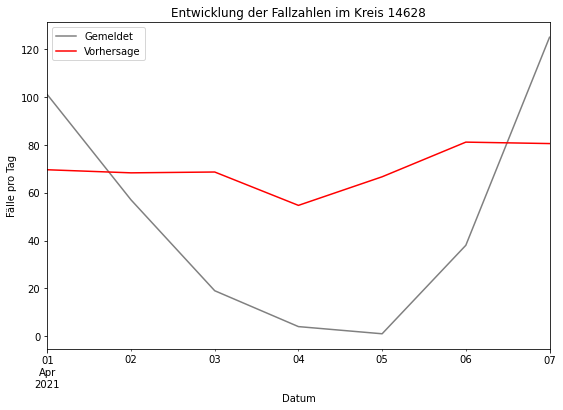

MSE
42.329304439795564


R²
-0.02905675739582758


In [27]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten Vorbereitung Vorhersage
    df_train = train_arima.xs(kreis_id)
    df_test = test_arima.xs(kreis_id)
    df_pred = df_test.loc[prediction_time]
    
    # Grid Search
    #grid_search=pmdarima.auto_arima(df_train['AnzahlFall'], trace=True) # Bestes Ergebnis: >> ARIMA(5,1,2)(0,0,0)[0] <<
    
    
    # Training
    train_set = df_train['AnzahlFall']
    model = sm.arima.model.ARIMA(train_set, order=(5, 1, 2))
    model = model.fit()
    
    
    # Vorhersage
    predictions = []
    for predict_date in prediction_time:
        prediction = model.predict(predict_date)
        predictions.append(prediction[0])
    
    df_pred['AnzahlFall_Vorhersage'] = predictions
    
    
    # Daten Plot
    yPlot = df_pred['AnzahlFall']
    zPlot = df_pred['AnzahlFall_Vorhersage']

    
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/arima_seven_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))

**5) MLP ohne Landkreisdaten**

In [28]:
# Test MLP
model = keras.models.load_model('models/mlp.h5')
test_mlp = pd.read_pickle('data/test_mlp.pkl')
test_mlp = test_mlp.groupby(['IdLandkreis', 'Meldedatum']).last() # Multiindex

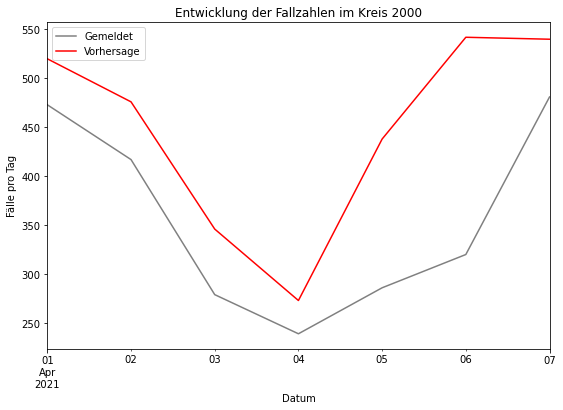

MSE
91.42857142857143


R²
-0.48185874436196086


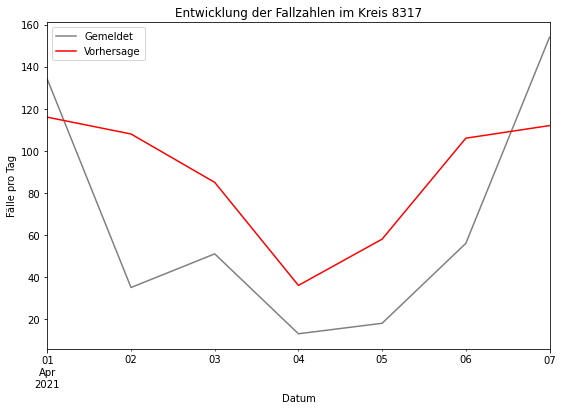

MSE
40.0


R²
0.2965257901467633


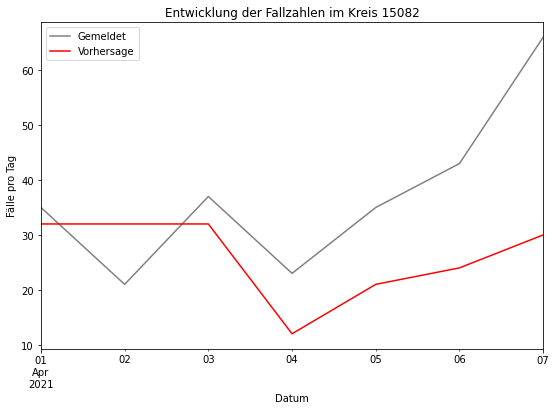

MSE
14.142857142857142


R²
-0.5925411412695021


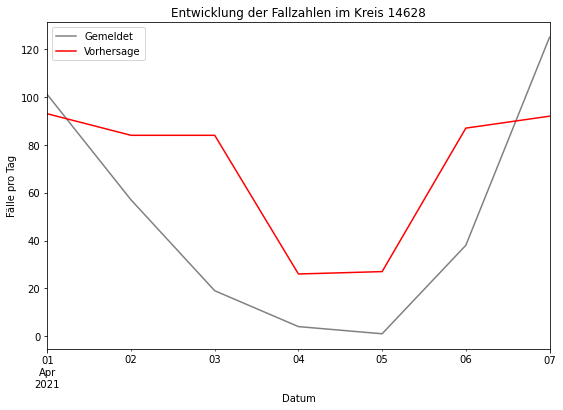

MSE
32.857142857142854


R²
0.304131449606186


In [29]:
for kreis_id in bechmark_kreise_ids:
    
    # Datengrundlage
    df = test_mlp.xs(kreis_id)
    df = df.loc[prediction_time]

    df_pred = df[['AnzahlFall_Vortag', 'AnzahlFall_Vorzweitag', 'AnzahlFall_Vordreitag', 'AnzahlFall_Vorviertag', 'AnzahlFall_Vorfünftag', 'AnzahlFall_Vorsechstag', 'AnzahlFall_Vorwoche', 'Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']]
    df_pred['AnzahlFall_Vorhersage'] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-01'), ['AnzahlFall_Vortag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-02'), ['AnzahlFall_Vorzweitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-03'), ['AnzahlFall_Vordreitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-04'), ['AnzahlFall_Vorviertag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-05'), ['AnzahlFall_Vorfünftag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-06'), ['AnzahlFall_Vorsechstag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorwoche']] = np.nan

    
    # Vorhersage
    for date in df_pred.index:
        
        date_nextday = date+pd.to_timedelta(1, unit='d')
        date_nexttwoday = date+pd.to_timedelta(2, unit='d')
        date_nextthreeday = date+pd.to_timedelta(3, unit='d')
        date_nextfourday = date+pd.to_timedelta(4, unit='d')
        date_nextfiveday = date+pd.to_timedelta(5, unit='d')
        date_nextsixday = date+pd.to_timedelta(6, unit='d')
        date_nextweek = date+pd.to_timedelta(7, unit='d')
        

        row_values = df_pred.loc[date]
        X_pred = row_values[['AnzahlFall_Vortag', 'AnzahlFall_Vorzweitag', 'AnzahlFall_Vordreitag', 'AnzahlFall_Vorviertag', 'AnzahlFall_Vorfünftag', 'AnzahlFall_Vorsechstag', 'AnzahlFall_Vorwoche', 'Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']]
        X_pred = X_pred.values
        X_pred = X_pred.reshape(1, 14)


        prediction = model.predict(X_pred)

        df_pred.loc[date, 'AnzahlFall_Vorhersage'] = prediction[0][0]
        df_pred.loc[date_nextday, 'AnzahlFall_Vortag'] = prediction[0][0]
        df_pred.loc[date_nexttwoday, 'AnzahlFall_Vorzweitag'] = prediction[0][0]
        df_pred.loc[date_nextthreeday, 'AnzahlFall_Vordreitag'] = prediction[0][0]
        df_pred.loc[date_nextfourday, 'AnzahlFall_Vorviertag'] = prediction[0][0]
        df_pred.loc[date_nextfiveday, 'AnzahlFall_Vorfünftag'] = prediction[0][0]
        df_pred.loc[date_nextsixday, 'AnzahlFall_Vorsechstag'] = prediction[0][0]
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorwoche'] = prediction[0][0]
        

    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'].round()
    df['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'] 
    
    
    # Daten Plot
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']

    
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/mlp_seven_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**6) MLP mit den Ergebnissen des Clusterings**

In [30]:
# Test MLP
model = keras.models.load_model('models/mlp_mit.h5')
test_mlp_mit = pd.read_pickle('data/test_mlp_mit.pkl')
test_mlp_mit = test_mlp_mit.groupby(['IdLandkreis', 'Meldedatum']).last() # Multiindex

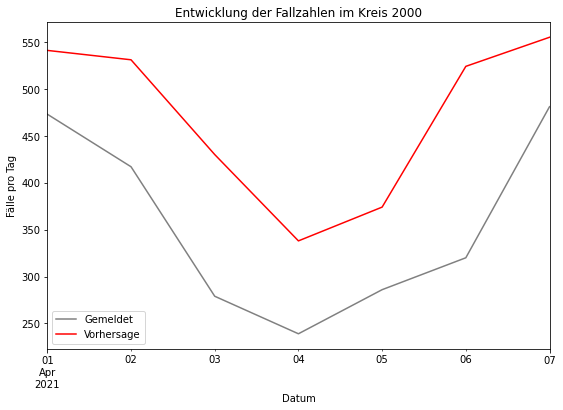

MSE
114.0


R²
-0.7852520063893729


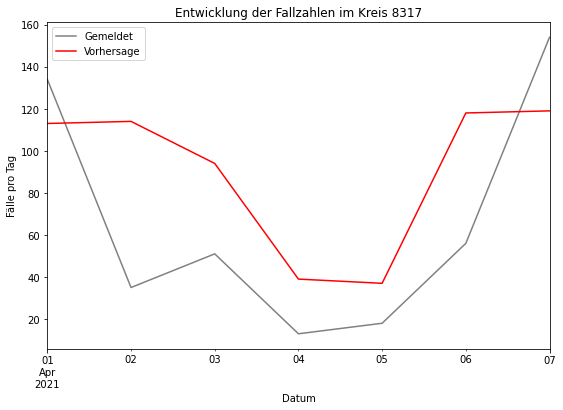

MSE
40.714285714285715


R²
0.22006120211923752


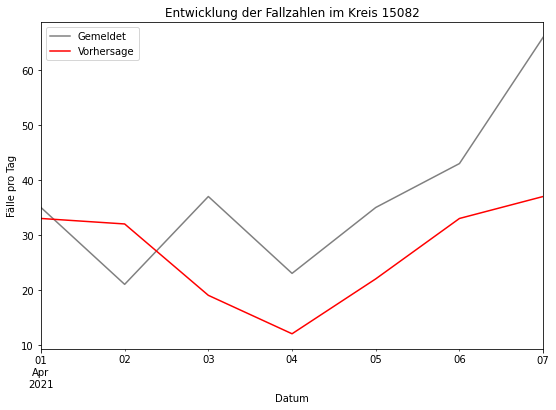

MSE
13.428571428571429


R²
-0.2566787775165633


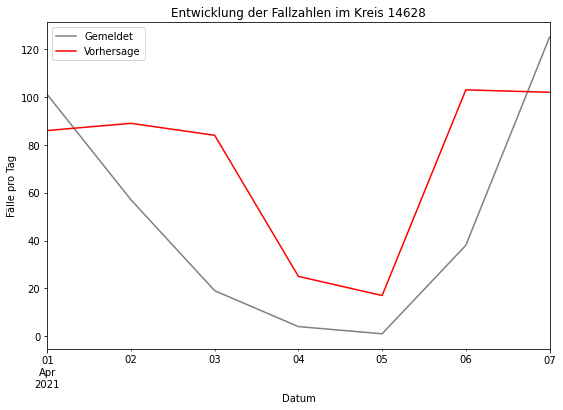

MSE
33.857142857142854


R²
0.21365702181915414


In [31]:
for kreis_id in bechmark_kreise_ids:
    
    # Datengrundlage
    df = test_mlp_mit.xs(kreis_id)
    df = df.loc[prediction_time]

    df_pred = df.copy()
    df_pred.drop('AnzahlFall', inplace=True, axis=1)
    
    df_pred['AnzahlFall_Vorhersage'] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-01'), ['AnzahlFall_Vortag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-02'), ['AnzahlFall_Vorzweitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-03'), ['AnzahlFall_Vordreitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-04'), ['AnzahlFall_Vorviertag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-05'), ['AnzahlFall_Vorfünftag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-06'), ['AnzahlFall_Vorsechstag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorwoche']] = np.nan

    
    # Vorhersage
    for date in df_pred.index:
        
        date_nextday = date+pd.to_timedelta(1, unit='d')
        date_nexttwoday = date+pd.to_timedelta(2, unit='d')
        date_nextthreeday = date+pd.to_timedelta(3, unit='d')
        date_nextfourday = date+pd.to_timedelta(4, unit='d')
        date_nextfiveday = date+pd.to_timedelta(5, unit='d')
        date_nextsixday = date+pd.to_timedelta(6, unit='d')
        date_nextweek = date+pd.to_timedelta(7, unit='d')
        

        row_values = df_pred.loc[date]
        X_pred = row_values[:-1]
        X_pred = X_pred.values
        X_pred = X_pred.reshape(1, 30)


        prediction = model.predict(X_pred)

        df_pred.loc[date, 'AnzahlFall_Vorhersage'] = prediction[0][0]
        df_pred.loc[date_nextday, 'AnzahlFall_Vortag'] = prediction[0][0]
        df_pred.loc[date_nexttwoday, 'AnzahlFall_Vorzweitag'] = prediction[0][0]
        df_pred.loc[date_nextthreeday, 'AnzahlFall_Vordreitag'] = prediction[0][0]
        df_pred.loc[date_nextfourday, 'AnzahlFall_Vorviertag'] = prediction[0][0]
        df_pred.loc[date_nextfiveday, 'AnzahlFall_Vorfünftag'] = prediction[0][0]
        df_pred.loc[date_nextsixday, 'AnzahlFall_Vorsechstag'] = prediction[0][0]
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorwoche'] = prediction[0][0]
        

    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'].round()
    df['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'] 
    
    
    # Daten Plot
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']

    
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/mlp_mit_seven_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**7) RNN**

In [32]:
model = keras.models.load_model('models/rnn.h5')
test_rnn = pd.read_pickle('data/test_rnn.pkl')

with open("data/fallzahlen_minmax.json", "rb") as infile: 
    fallzahlen_minmax = json.load(infile)

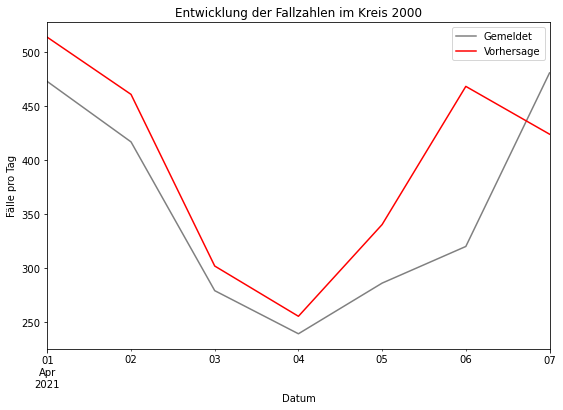

MSE
54.83905944228172


R²
0.4452337579225226


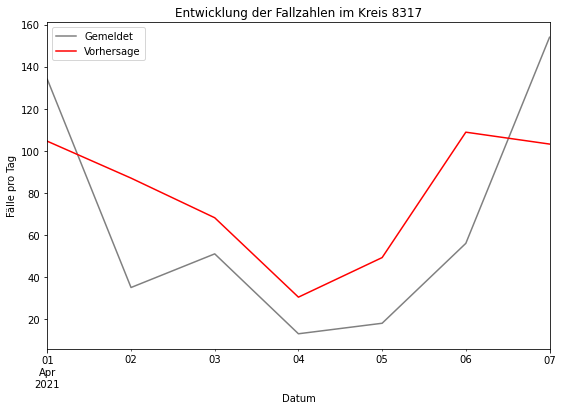

MSE
35.847489084516255


R²
0.43939399821385694


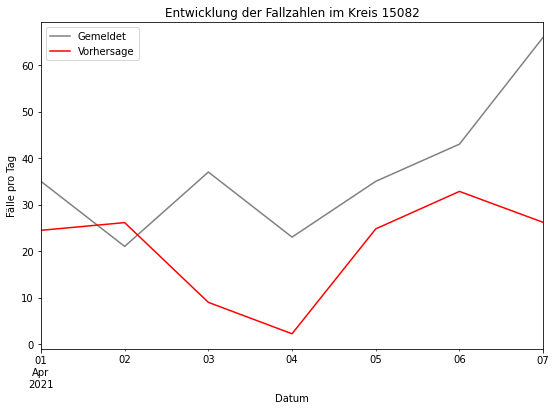

MSE
17.817593502146856


R²
-1.3565231535449525


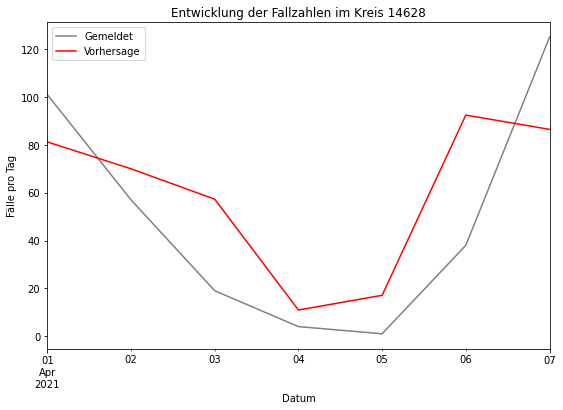

MSE
26.72061812531735


R²
0.5119362040300433


In [33]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten Vorbereitung Vorhersage
    df = test_rnn.xs(kreis_id)
    df = df.loc[prediction_time]
    
    kreis_min = fallzahlen_minmax[f'{kreis_id}'][0]
    kreis_max = fallzahlen_minmax[f'{kreis_id}'][1]
    
    df_pred = df.drop('AnzahlFall', inplace=False, axis=1)
    
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-01'), ['AnzahlFall_Vortag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-02'), ['AnzahlFall_Vorzweitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-03'), ['AnzahlFall_Vordreitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-04'), ['AnzahlFall_Vorviertag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-05'), ['AnzahlFall_Vorfünftag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-06'), ['AnzahlFall_Vorsechstag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorwoche']] = np.nan
    
    predictions = []
    
    for date in df_pred.index:
        
        date_nextday = date+pd.to_timedelta(1, unit='d')
        date_nexttwoday = date+pd.to_timedelta(2, unit='d')
        date_nextthreeday = date+pd.to_timedelta(3, unit='d')
        date_nextfourday = date+pd.to_timedelta(4, unit='d')
        date_nextfiveday = date+pd.to_timedelta(5, unit='d')
        date_nextsixday = date+pd.to_timedelta(6, unit='d')
        date_nextweek = date+pd.to_timedelta(7, unit='d')
        
        row_values = df_pred.loc[date]
        X_pred = row_values.to_xarray()
        X_pred = X_pred.transpose()
        X_pred = X_pred.values
        X_pred = np.expand_dims(X_pred, axis=1)
        X_pred = np.expand_dims(X_pred, axis=0)
        
        prediction = model.predict(X_pred)
        
        predictions.append(prediction[0][0])
        df_pred.loc[date_nextday, 'AnzahlFall_Vortag'] = prediction[0][0]
        df_pred.loc[date_nexttwoday, 'AnzahlFall_Vorzweitag'] = prediction[0][0]
        df_pred.loc[date_nextthreeday, 'AnzahlFall_Vordreitag'] = prediction[0][0]
        df_pred.loc[date_nextfourday, 'AnzahlFall_Vorviertag'] = prediction[0][0]
        df_pred.loc[date_nextfiveday, 'AnzahlFall_Vorfünftag'] = prediction[0][0]
        df_pred.loc[date_nextsixday, 'AnzahlFall_Vorsechstag'] = prediction[0][0]
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorwoche'] = prediction[0][0]
    
    
     # Daten
    df['AnzahlFall_Vorhersage'] = predictions
    
    yPlot = df['AnzahlFall']*(kreis_max-kreis_min)+kreis_min
    zPlot = df['AnzahlFall_Vorhersage']*(kreis_max-kreis_min)+kreis_min
    
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/rnn_seven_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=yPlot, y_pred=zPlot))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=yPlot, y_pred=zPlot))
    

## Total-Period-Vorhersage
zum Zeitpunkt 01. April 2021 für den gesamten Zeitraum 01. April 2021 bis 20. Mai 2021

In [34]:
start_time = pd.to_datetime('2021-04-01')
end_time = pd.to_datetime('2021-05-20')
prediction_time = pd.date_range(start_time, end_time, freq='D')

**1) Naïve / SNaïve**

In [35]:
# Daten laden
test_naive = pd.read_pickle('data/test_naive.pkl')

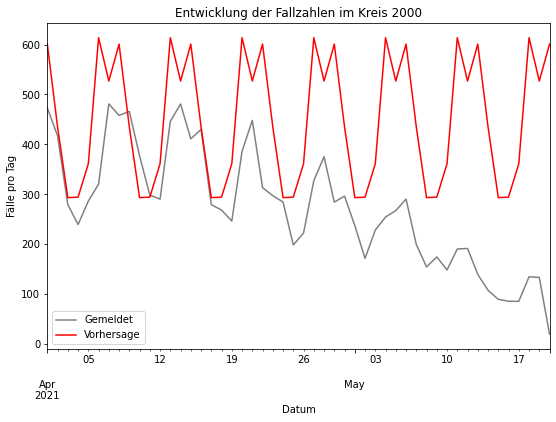

MSE
180.9


R²
-2.7081558318906866


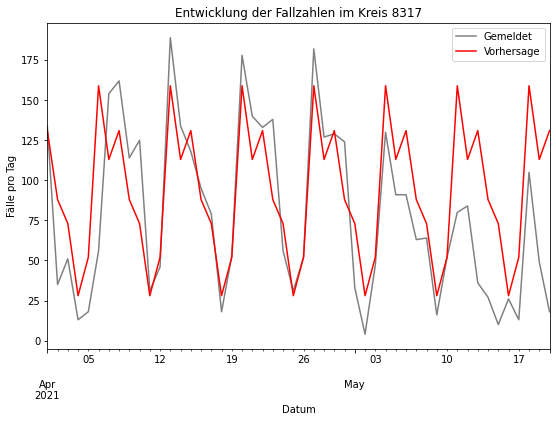

MSE
29.5


R²
0.40461138157589416


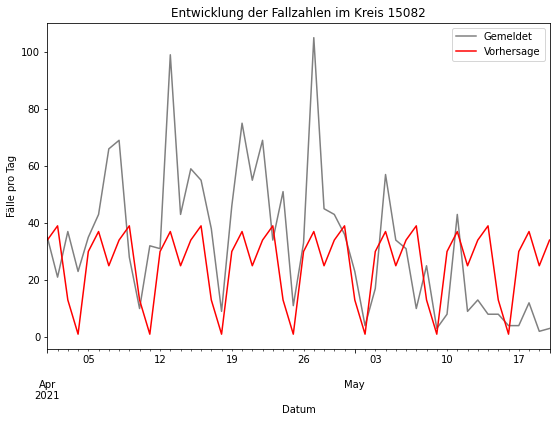

MSE
18.74


R²
0.041580565292008376


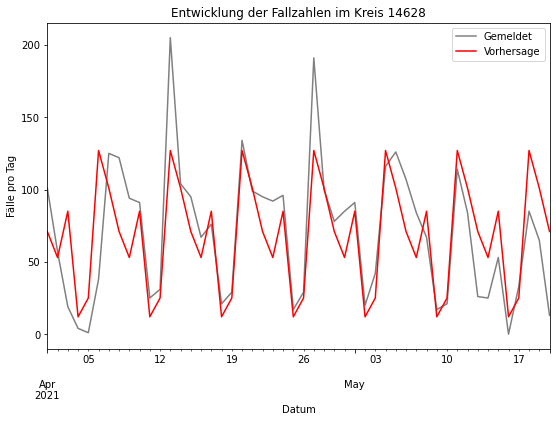

MSE
23.02


R²
0.5511617932269133


In [36]:
for kreis_id in bechmark_kreise_ids:
    
    # Datengrundlage
    df = test_naive.xs(kreis_id)
    df['AnzahlFall_Vorhersage'] = np.nan
    df_pred = df[['AnzahlFall_Vorhersage', 'AnzahlFall_Vorwoche']]
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorwoche']] = np.nan
    
    # Vorhersage
    for date in df_pred.index:
        row_values = df_pred.loc[date]
        date_nextweek = date+pd.to_timedelta(7, unit='d')
        prediction = df_pred.loc[date, 'AnzahlFall_Vorwoche']
        df_pred.loc[date, 'AnzahlFall_Vorhersage'] = prediction
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorwoche'] = prediction
    
    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'].round()
    df['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'] 
    
    
    # Daten
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/naive_total_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**2) SNaïve mit wöchentlicher Trendkomponente**

In [37]:
# Daten laden
test_naive_trend = pd.read_pickle('data/test_naive_trend.pkl')

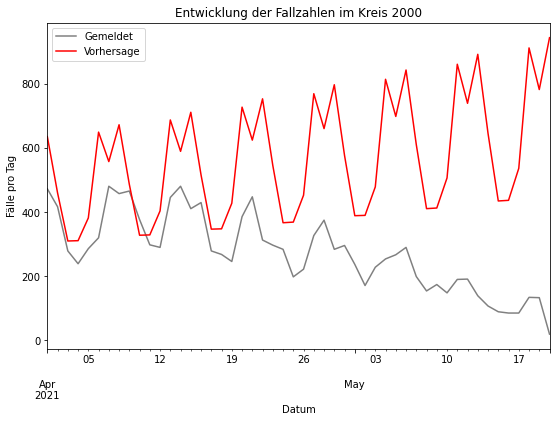

MSE
299.66


R²
-8.760249743573064


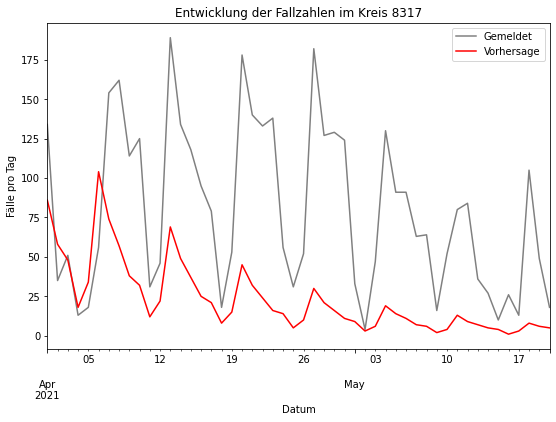

MSE
59.3


R²
-0.9036058158589015


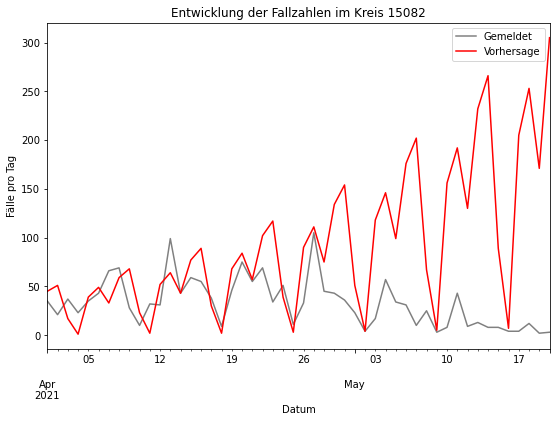

MSE
67.36


R²
-16.683022111102428


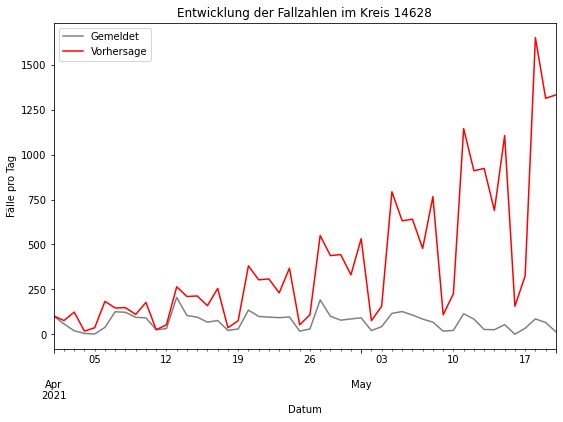

MSE
327.6


R²
-117.33844920184994


In [38]:
for kreis_id in bechmark_kreise_ids:
    
    
    # Datengrundlage
    df = test_naive_trend.xs(kreis_id)
    df['AnzahlFall_Vorhersage'] = np.nan
    df_pred = df[['AnzahlFall_Vorhersage', 'AnzahlFall_Vortag', 'AnzahlFall_Vorwoche', 'AnzahlFall_Vortagwoche']]
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-01'), ['AnzahlFall_Vortag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorwoche']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-08'), ['AnzahlFall_Vortagwoche']] = np.nan


    # Vorhersage
    for date in df_pred.index:
        
        date_nextday = date+pd.to_timedelta(1, unit='d')
        date_nextweek = date+pd.to_timedelta(7, unit='d')
        date_nextweekday = date+pd.to_timedelta(8, unit='d')
        
        row_values  = df_pred.loc[date]
        prediction = row_values['AnzahlFall_Vorwoche']*(row_values['AnzahlFall_Vortag']/row_values['AnzahlFall_Vortagwoche'])
        
        df_pred.loc[date, 'AnzahlFall_Vorhersage'] = prediction
        df_pred.loc[date_nextday, 'AnzahlFall_Vortag'] = prediction
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorwoche'] = prediction
        df_pred.loc[date_nextweekday, 'AnzahlFall_Vortagwoche'] = prediction
        

    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'].round()
    df['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'] 


    # Daten
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/naivetrend_total_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**3) Exponentielle Glättung**

In [39]:
# Daten laden
train_smoothing = pd.read_pickle('data/train_smoothing.pkl')
test_smoothing = pd.read_pickle('data/test_smoothing.pkl')

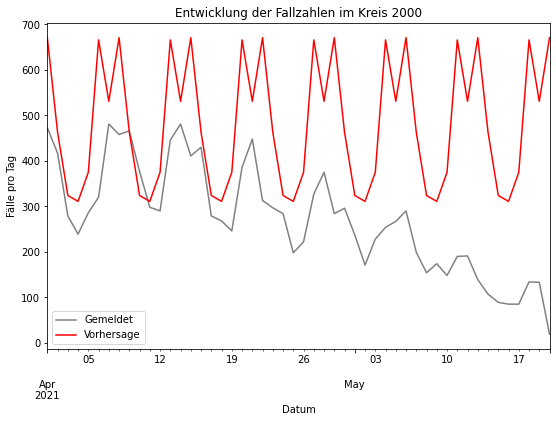

MSE
210.02


R²
-3.8102830494121154


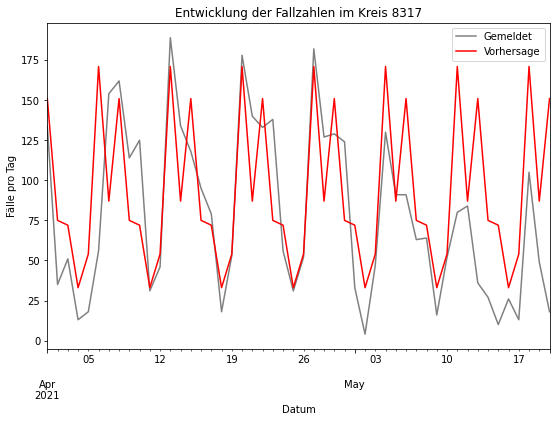

MSE
33.52


R²
0.22895719860101427


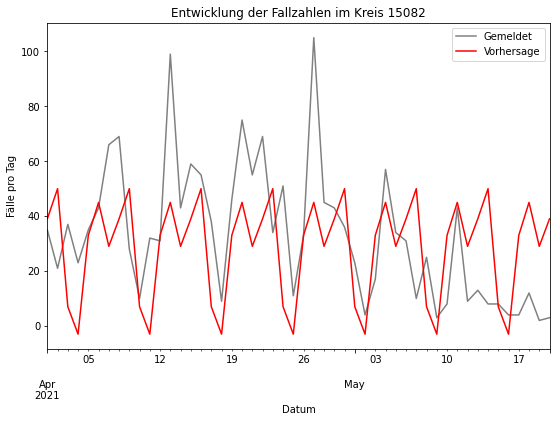

MSE
20.02


R²
-0.02388791150170655


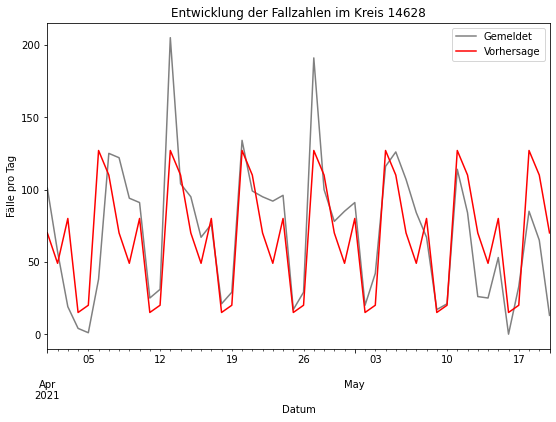

MSE
23.98


R²
0.538630091004028


In [40]:
alpha = 0.3

for kreis_id in bechmark_kreise_ids:
    
    # Datengrundlage
    df1 = train_smoothing.xs(kreis_id)
    df2 = test_smoothing.xs(kreis_id)
    df = pd.concat([df1, df2])
    df['AnzahlFall_Vorhersage'] = np.nan
    
    
    # Datengrundlage mit alten Vorhersagen
    for date in df.index:
     
        row_values = df.loc[date]
    
        if date < pd.to_datetime('2020-03-08'):
            df.loc[date, 'AnzahlFall_Vorhersage'] = row_values['AnzahlFall'] # Erste 7 Tage initialisieren
        
        else:
            date_lastweek = date-pd.to_timedelta(7, unit='d')
            case_prediction_lastweek = df.loc[date_lastweek, 'AnzahlFall_Vorhersage']
            df.loc[date, 'AnzahlFall_Vorhersage'] = row_values['AnzahlFall_Vorwoche'] + alpha*(row_values['AnzahlFall_Vorwoche'] - case_prediction_lastweek)
 
    df['AnzahlFall_Vorhersage_Vorwoche'] = df['AnzahlFall_Vorhersage'].shift(periods=7)
    
    
    df = df['2021-04-01':]
    df_pred = df
    df_pred['AnzahlFall_Vorhersage'] = np.nan
    df_pred = df[['AnzahlFall_Vorhersage', 'AnzahlFall_Vorwoche', 'AnzahlFall_Vorhersage_Vorwoche']]
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorwoche']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorhersage_Vorwoche']] = np.nan

    

    # Vorhersage
    for date in df_pred.index:
        

        date_nextweek = date+pd.to_timedelta(7, unit='d')
        
        row_values = df_pred.loc[date]
        prediction = row_values['AnzahlFall_Vorwoche']+alpha*(row_values['AnzahlFall_Vorwoche']-row_values['AnzahlFall_Vorhersage_Vorwoche'])

        
        df_pred.loc[date, 'AnzahlFall_Vorhersage'] = prediction
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorwoche'] = prediction
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorhersage_Vorwoche'] = prediction
        

    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'].round()
    df['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'] 


    # Daten
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/smoothing_total_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**4) ARIMA**

In [41]:
# Daten laden
train_arima = pd.read_pickle('data/train_arima.pkl')
test_arima = pd.read_pickle('data/test_arima.pkl')

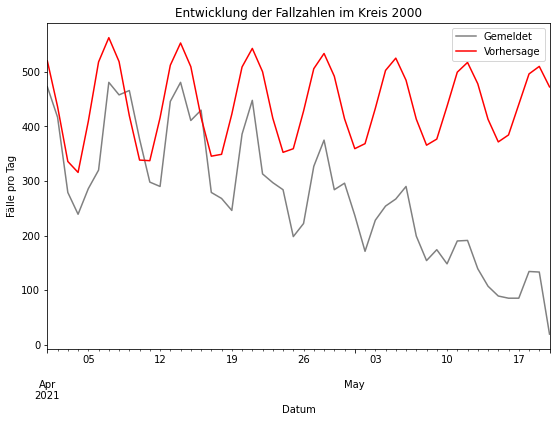

MSE
173.45927102812828


R²
-1.967944133191132


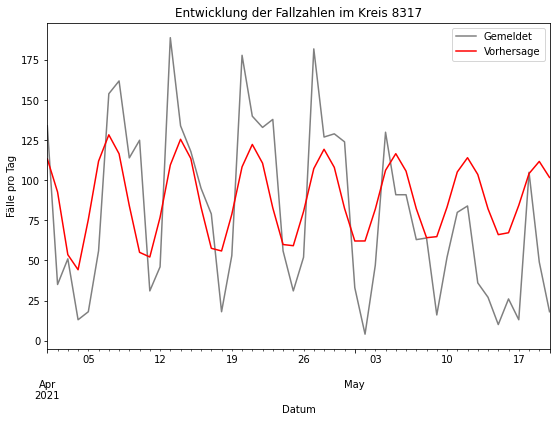

MSE
35.76561846721714


R²
0.33787725718293904


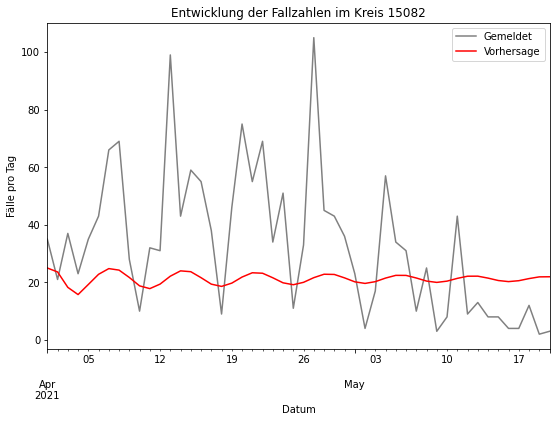

MSE
20.597601780238698


R²
-0.18547148574743244


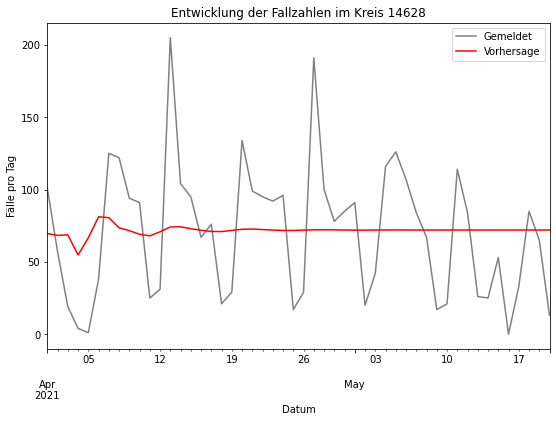

MSE
37.75727022053511


R²
0.04270858760919782


In [42]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten Vorbereitung Vorhersage
    df_train = train_arima.xs(kreis_id)
    df_pred = test_arima.xs(kreis_id)
    
    # Grid Search
    #grid_search=pmdarima.auto_arima(df_train['AnzahlFall'], trace=True) # Bestes Ergebnis: >> ARIMA(5,1,2)(0,0,0)[0] <<
    
    
    # Training
    train_set = df_train['AnzahlFall']
    model = sm.arima.model.ARIMA(train_set, order=(5, 1, 2))
    model = model.fit()
    
    
    # Vorhersage
    predictions = []
    for predict_date in prediction_time:
        prediction = model.predict(predict_date)
        predictions.append(prediction[0])
    
    df_pred['AnzahlFall_Vorhersage'] = predictions
    
    
    # Daten Plot
    yPlot = df_pred['AnzahlFall']
    zPlot = df_pred['AnzahlFall_Vorhersage']

    
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/arima_total_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df_pred['AnzahlFall'], y_pred=df_pred['AnzahlFall_Vorhersage']))

**5) MLP ohne Landkreisdaten**

In [43]:
# Test MLP
model = keras.models.load_model('models/mlp.h5')
test_mlp = pd.read_pickle('data/test_mlp.pkl')
test_mlp = test_mlp.groupby(['IdLandkreis', 'Meldedatum']).last() # Multiindex

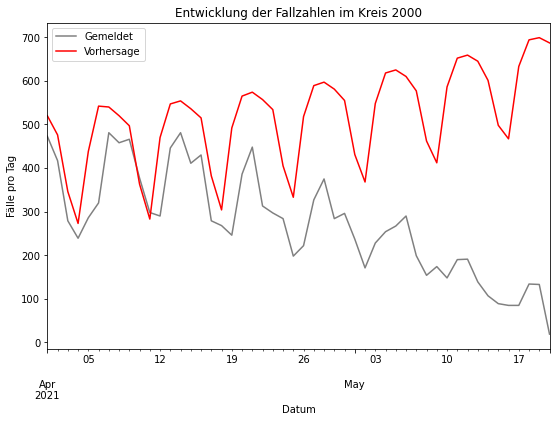

MSE
245.34


R²
-5.327018241231469


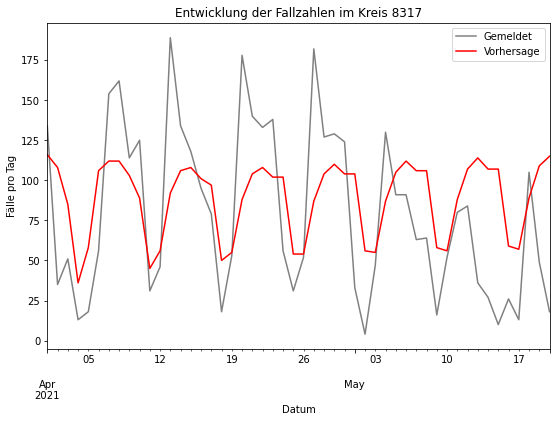

MSE
37.7


R²
0.19792002599000635


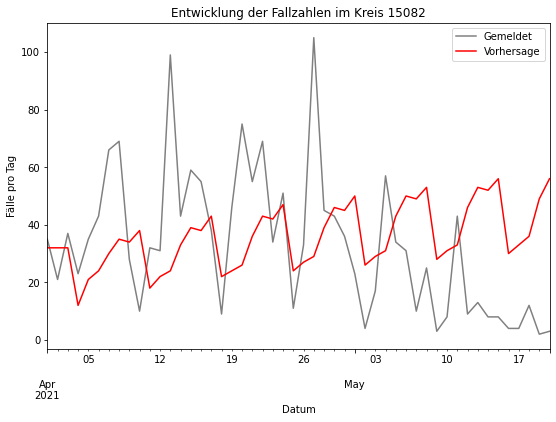

MSE
23.18


R²
-0.3960209714659817


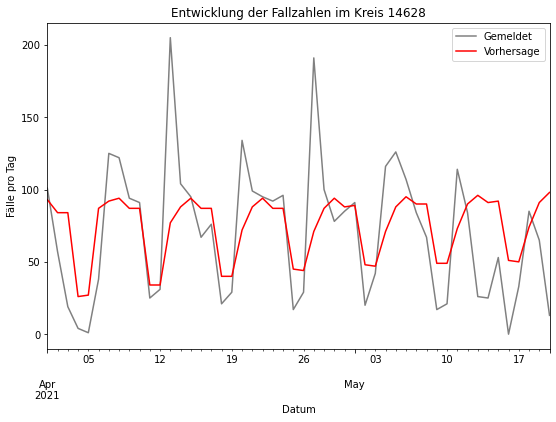

MSE
28.02


R²
0.2692544383112039


In [44]:
for kreis_id in bechmark_kreise_ids:
    
    # Datengrundlage
    df = test_mlp.xs(kreis_id)
    

    df_pred = df[['AnzahlFall_Vortag', 'AnzahlFall_Vorzweitag', 'AnzahlFall_Vordreitag', 'AnzahlFall_Vorviertag', 'AnzahlFall_Vorfünftag', 'AnzahlFall_Vorsechstag', 'AnzahlFall_Vorwoche', 'Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']]
    df_pred['AnzahlFall_Vorhersage'] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-01'), ['AnzahlFall_Vortag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-02'), ['AnzahlFall_Vorzweitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-03'), ['AnzahlFall_Vordreitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-04'), ['AnzahlFall_Vorviertag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-05'), ['AnzahlFall_Vorfünftag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-06'), ['AnzahlFall_Vorsechstag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorwoche']] = np.nan

    
    # Vorhersage
    for date in df_pred.index:
        
        date_nextday = date+pd.to_timedelta(1, unit='d')
        date_nexttwoday = date+pd.to_timedelta(2, unit='d')
        date_nextthreeday = date+pd.to_timedelta(3, unit='d')
        date_nextfourday = date+pd.to_timedelta(4, unit='d')
        date_nextfiveday = date+pd.to_timedelta(5, unit='d')
        date_nextsixday = date+pd.to_timedelta(6, unit='d')
        date_nextweek = date+pd.to_timedelta(7, unit='d')
        

        row_values = df_pred.loc[date]
        X_pred = row_values[['AnzahlFall_Vortag', 'AnzahlFall_Vorzweitag', 'AnzahlFall_Vordreitag', 'AnzahlFall_Vorviertag', 'AnzahlFall_Vorfünftag', 'AnzahlFall_Vorsechstag', 'AnzahlFall_Vorwoche', 'Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']]
        X_pred = X_pred.values
        X_pred = X_pred.reshape(1, 14)


        prediction = model.predict(X_pred)

        df_pred.loc[date, 'AnzahlFall_Vorhersage'] = prediction[0][0]
        df_pred.loc[date_nextday, 'AnzahlFall_Vortag'] = prediction[0][0]
        df_pred.loc[date_nexttwoday, 'AnzahlFall_Vorzweitag'] = prediction[0][0]
        df_pred.loc[date_nextthreeday, 'AnzahlFall_Vordreitag'] = prediction[0][0]
        df_pred.loc[date_nextfourday, 'AnzahlFall_Vorviertag'] = prediction[0][0]
        df_pred.loc[date_nextfiveday, 'AnzahlFall_Vorfünftag'] = prediction[0][0]
        df_pred.loc[date_nextsixday, 'AnzahlFall_Vorsechstag'] = prediction[0][0]
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorwoche'] = prediction[0][0]
        

    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'].round()
    df['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'] 
    
    
    # Daten Plot
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']

    
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/mlp_total_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**6) MLP mit den Ergebnissen des Clusterings**

In [45]:
# Test MLP
model = keras.models.load_model('models/mlp_mit.h5')
test_mlp_mit = pd.read_pickle('data/test_mlp_mit.pkl')
test_mlp_mit = test_mlp_mit.groupby(['IdLandkreis', 'Meldedatum']).last() # Multiindex

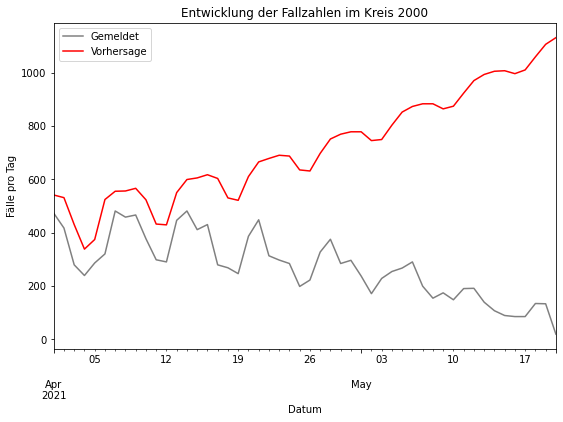

MSE
445.0


R²
-19.355204049088627


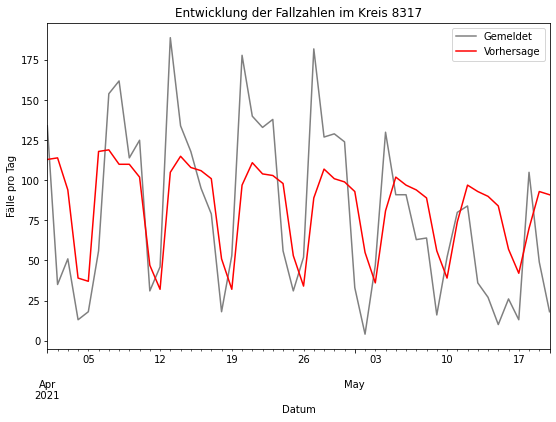

MSE
34.76


R²
0.36100463750248424


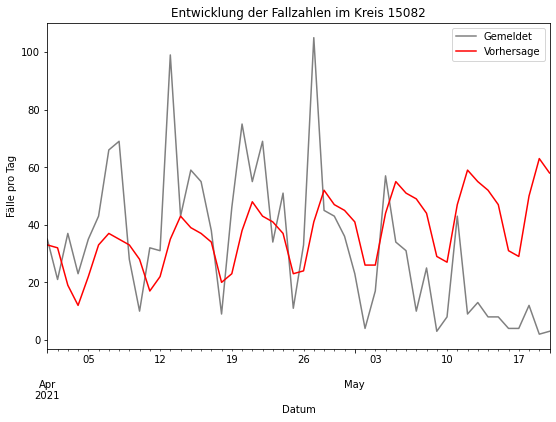

MSE
22.04


R²
-0.275759690277527


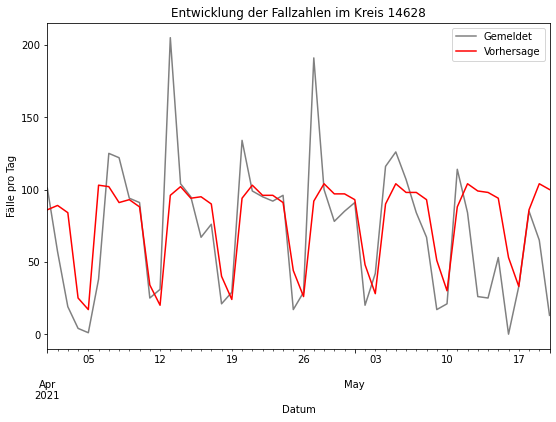

MSE
25.7


R²
0.368594286140534


In [46]:
for kreis_id in bechmark_kreise_ids:
    
    # Datengrundlage
    df = test_mlp_mit.xs(kreis_id)


    df_pred = df.copy()
    df_pred.drop('AnzahlFall', inplace=True, axis=1)
    df_pred['AnzahlFall_Vorhersage'] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-01'), ['AnzahlFall_Vortag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-02'), ['AnzahlFall_Vorzweitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-03'), ['AnzahlFall_Vordreitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-04'), ['AnzahlFall_Vorviertag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-05'), ['AnzahlFall_Vorfünftag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-06'), ['AnzahlFall_Vorsechstag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorwoche']] = np.nan

    
    # Vorhersage
    for date in df_pred.index:
        
        date_nextday = date+pd.to_timedelta(1, unit='d')
        date_nexttwoday = date+pd.to_timedelta(2, unit='d')
        date_nextthreeday = date+pd.to_timedelta(3, unit='d')
        date_nextfourday = date+pd.to_timedelta(4, unit='d')
        date_nextfiveday = date+pd.to_timedelta(5, unit='d')
        date_nextsixday = date+pd.to_timedelta(6, unit='d')
        date_nextweek = date+pd.to_timedelta(7, unit='d')
    
    

        row_values = df_pred.loc[date]
        X_pred = row_values[:-1]
        X_pred = X_pred.values
        X_pred = X_pred.reshape(1, 30)


        prediction = model.predict(X_pred)

        df_pred.loc[date, 'AnzahlFall_Vorhersage'] = prediction[0][0]
        df_pred.loc[date_nextday, 'AnzahlFall_Vortag'] = prediction[0][0]
        df_pred.loc[date_nexttwoday, 'AnzahlFall_Vorzweitag'] = prediction[0][0]
        df_pred.loc[date_nextthreeday, 'AnzahlFall_Vordreitag'] = prediction[0][0]
        df_pred.loc[date_nextfourday, 'AnzahlFall_Vorviertag'] = prediction[0][0]
        df_pred.loc[date_nextfiveday, 'AnzahlFall_Vorfünftag'] = prediction[0][0]
        df_pred.loc[date_nextsixday, 'AnzahlFall_Vorsechstag'] = prediction[0][0]
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorwoche'] = prediction[0][0]
        

    df_pred['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'].round()
    df['AnzahlFall_Vorhersage'] = df_pred['AnzahlFall_Vorhersage'] 
    
    
    # Daten Plot
    yPlot = df['AnzahlFall']
    zPlot = df['AnzahlFall_Vorhersage']

    
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/mlp_total_mit_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=df['AnzahlFall'], y_pred=df['AnzahlFall_Vorhersage']))

**7) RNN**

In [47]:
model = keras.models.load_model('models/rnn.h5')
test_rnn = pd.read_pickle('data/test_rnn.pkl')

with open("data/fallzahlen_minmax.json", "rb") as infile: 
    fallzahlen_minmax = json.load(infile)

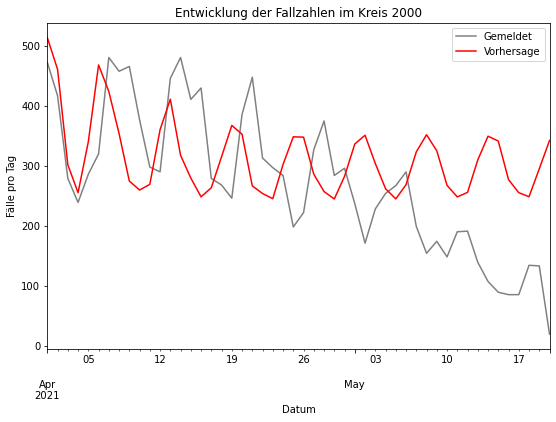

MSE
103.48076077699662


R²
-0.1401391770271494


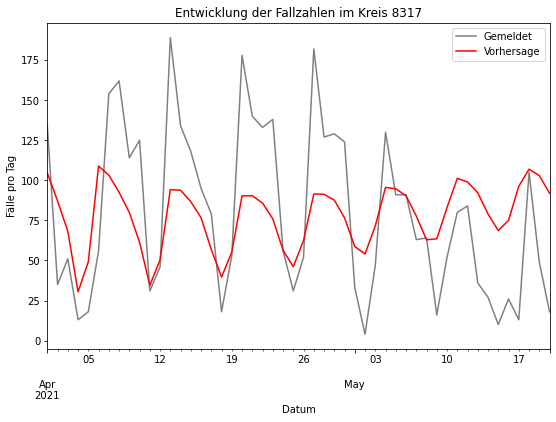

MSE
36.858273639678956


R²
0.25931182135091224


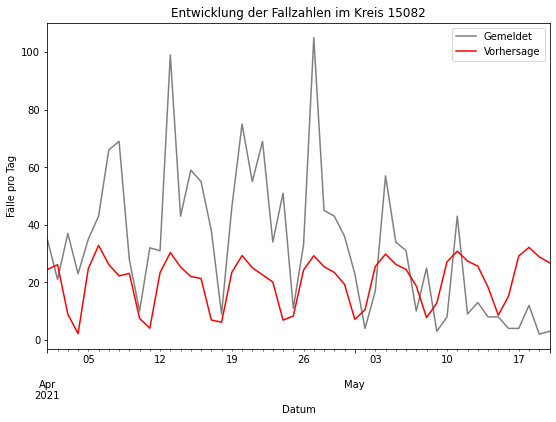

MSE
20.788282398879527


R²
-0.16543173038306658


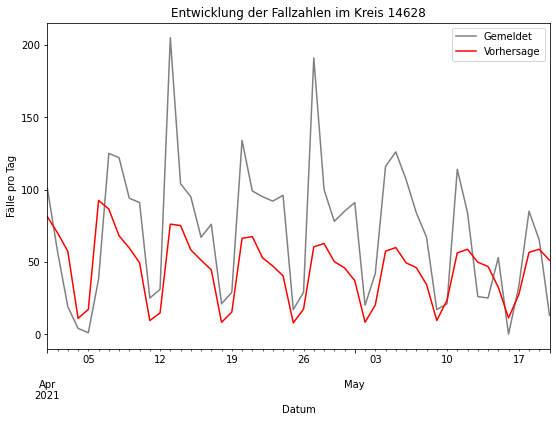

MSE
34.094481674060226


R²
0.14120074948393357


In [48]:
for kreis_id in bechmark_kreise_ids:
    
    # Daten Vorbereitung Vorhersage

    df = test_rnn.xs(kreis_id)
    kreis_min = fallzahlen_minmax[f'{kreis_id}'][0]
    kreis_max = fallzahlen_minmax[f'{kreis_id}'][1]
    
    
    df_pred = df.drop('AnzahlFall', inplace=False, axis=1)
    
    
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-01'), ['AnzahlFall_Vortag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-02'), ['AnzahlFall_Vorzweitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-03'), ['AnzahlFall_Vordreitag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-04'), ['AnzahlFall_Vorviertag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-05'), ['AnzahlFall_Vorfünftag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-06'), ['AnzahlFall_Vorsechstag']] = np.nan
    df_pred.loc[df_pred.index > pd.to_datetime('2021-04-07'), ['AnzahlFall_Vorwoche']] = np.nan
    
    
    predictions = []
    
    for date in df_pred.index:
        
        date_nextday = date+pd.to_timedelta(1, unit='d')
        date_nexttwoday = date+pd.to_timedelta(2, unit='d')
        date_nextthreeday = date+pd.to_timedelta(3, unit='d')
        date_nextfourday = date+pd.to_timedelta(4, unit='d')
        date_nextfiveday = date+pd.to_timedelta(5, unit='d')
        date_nextsixday = date+pd.to_timedelta(6, unit='d')
        date_nextweek = date+pd.to_timedelta(7, unit='d')
        
        row_values = df_pred.loc[date]
        X_pred = row_values.to_xarray()
        X_pred = X_pred.transpose()
        X_pred = X_pred.values
        X_pred = np.expand_dims(X_pred, axis=1)
        X_pred = np.expand_dims(X_pred, axis=0)
        
        prediction = model.predict(X_pred)
        
        predictions.append(prediction[0][0])
        df_pred.loc[date_nextday, 'AnzahlFall_Vortag'] = prediction[0][0]
        df_pred.loc[date_nexttwoday, 'AnzahlFall_Vorzweitag'] = prediction[0][0]
        df_pred.loc[date_nextthreeday, 'AnzahlFall_Vordreitag'] = prediction[0][0]
        df_pred.loc[date_nextfourday, 'AnzahlFall_Vorviertag'] = prediction[0][0]
        df_pred.loc[date_nextfiveday, 'AnzahlFall_Vorfünftag'] = prediction[0][0]
        df_pred.loc[date_nextsixday, 'AnzahlFall_Vorsechstag'] = prediction[0][0]
        df_pred.loc[date_nextweek, 'AnzahlFall_Vorwoche'] = prediction[0][0]
    
    
     # Daten
    df['AnzahlFall_Vorhersage'] = predictions
    
    yPlot = df['AnzahlFall']*(kreis_max-kreis_min)+kreis_min
    zPlot = df['AnzahlFall_Vorhersage']*(kreis_max-kreis_min)+kreis_min
    
    
    # Line Plots
    f, ax = plt.subplots(figsize=(9, 6))
    yPlot.plot(color='grey')
    zPlot.plot(color='red')
    ax.set_xlabel('Datum')
    ax.set_ylabel('Fälle pro Tag')
    plt.title(f"Entwicklung der Fallzahlen im Kreis {kreis_id}")
    ax.legend(('Gemeldet', 'Vorhersage'))
    plt.savefig(f"visualization/forecast/rnn_total_{kreis_id}.svg")
    plt.show()
    
    # MAE
    print("MAE")
    print(mean_absolute_error(y_true=yPlot, y_pred=zPlot))
    print("\n")
    # R²
    print("R²")
    print(r2_score(y_true=yPlot, y_pred=zPlot))